# Predicting Check-ins of Foursquare Users in Tokyo

## 2 - Exploratory Data Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import rcParams

%matplotlib inline

In [2]:
# Setup default matplotlib defaults for later use
def defaultsettings():
    rcParams.update(matplotlib.rcParamsDefault)
    sns.set_style()
    sns.set_context()
    %matplotlib inline

In [3]:
# Setup Seaborn settings for bar plots
def postersettings():
    rcParams.update(matplotlib.rcParamsDefault)
    sns.set_style("whitegrid")
    sns.set_context("poster")

In [4]:
# Define settings for plotting spatial coodinates of venues where users checked-in.
def mapsettings(x_size, y_size, dpi):
    plt.style.use('default')  # Styling
    new_style = {'grid': False} # Remove grid
    matplotlib.rc('axes', **new_style)
    rcParams['figure.figsize'] = (x_size, y_size) # Size of figure
    rcParams['figure.dpi'] = dpi
    rcParams['font.size'] = 16

In [5]:
# Load wrangled data.
df = pd.read_csv('df_afterwrangling.csv',
                 index_col = 0,
                 parse_dates = [0],
                 date_parser = pd.to_datetime, 
                 infer_datetime_format = True)
df_stations = pd.read_csv('stations.csv', index_col = 0)

In [6]:
df.head()

userid               venuecat        lat        long  \
timestamp                                                                   
2012-04-04 03:17:18    1541         Cosmetics Shop  35.705101  139.619590   
2012-04-04 03:22:04     868  Ramen /  Noodle House  35.715581  139.800317   
2012-04-04 04:12:07     114      Convenience Store  35.714542  139.480065   
2012-04-04 04:12:13     868      Food & Drink Shop  35.725592  139.776633   
2012-04-04 04:18:23    1458    Housing Development  35.656083  139.734046   

                     day  hour         maincat  venuecat_encoded  \
timestamp                                                          
2012-04-04 03:17:18    2     3  Shop & Service               129   
2012-04-04 03:22:04    2     3            Food                 2   
2012-04-04 04:12:07    2     4  Shop & Service                 3   
2012-04-04 04:12:13    2     4  Shop & Service                 6   
2012-04-04 04:18:23    2     4       Residence               212   

                     maincat_encoded  
timestamp                             
2012-04-04 03:17:18                1  
2012-04-04 03:22:04                2  
2012-04-04 04:12:07                1  
2012-04-04 04:12:13                1  
2012-04-04 04:18:23                8

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573703 entries, 2012-04-04 03:17:18 to 2013-02-16 11:35:29
Data columns (total 9 columns):
userid              573703 non-null int64
venuecat            573703 non-null object
lat                 573703 non-null float64
long                573703 non-null float64
day                 573703 non-null int64
hour                573703 non-null int64
maincat             573703 non-null object
venuecat_encoded    573703 non-null int64
maincat_encoded     573703 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 43.8+ MB


In [8]:
df_stations.head()

lat        long                            name           type
0  35.689738  139.700391                Shinjuku Station  Train Station
1  35.683689  139.698916         Minami-Shinjuku Station  Train Station
2  35.680986  139.686182                Hatsudai Station  Train Station
3  35.686888  139.698322  Toei Chikatetsuniijuku Station         Subway
4  35.690570  139.692661                   Tochōmae Sta.         Subway

In [9]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580 entries, 0 to 579
Data columns (total 4 columns):
lat     580 non-null float64
long    580 non-null float64
name    580 non-null object
type    580 non-null object
dtypes: float64(2), object(2)
memory usage: 22.7+ KB


### Display proportion of check-ins for each of 9 main venue categories

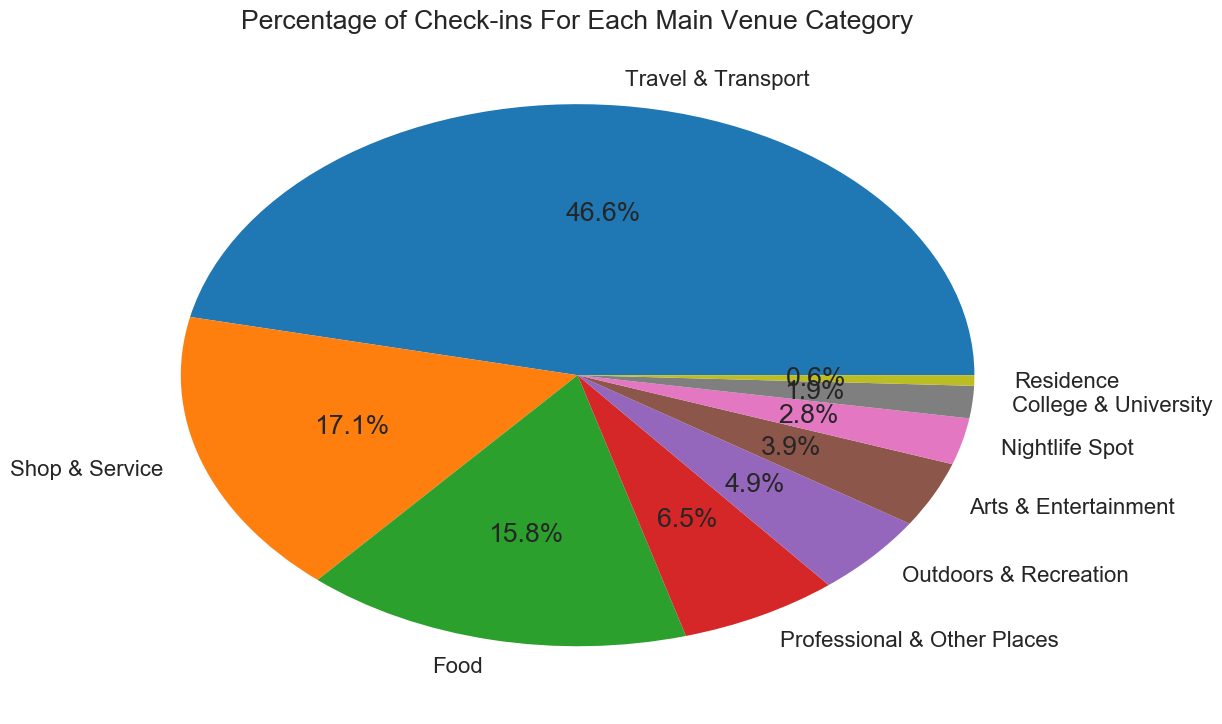

In [10]:
# Draw a pie chart showing the relative counts for each main category.
postersettings()

counts_maincat = df.maincat.value_counts()

plt.pie(counts_maincat, labels = counts_maincat.index, autopct = '%1.1f%%')
plt.title('Percentage of Check-ins For Each Main Venue Category')
plt.show()

### Deeper dive: display proportion of check-ins for each of 247 venue categories

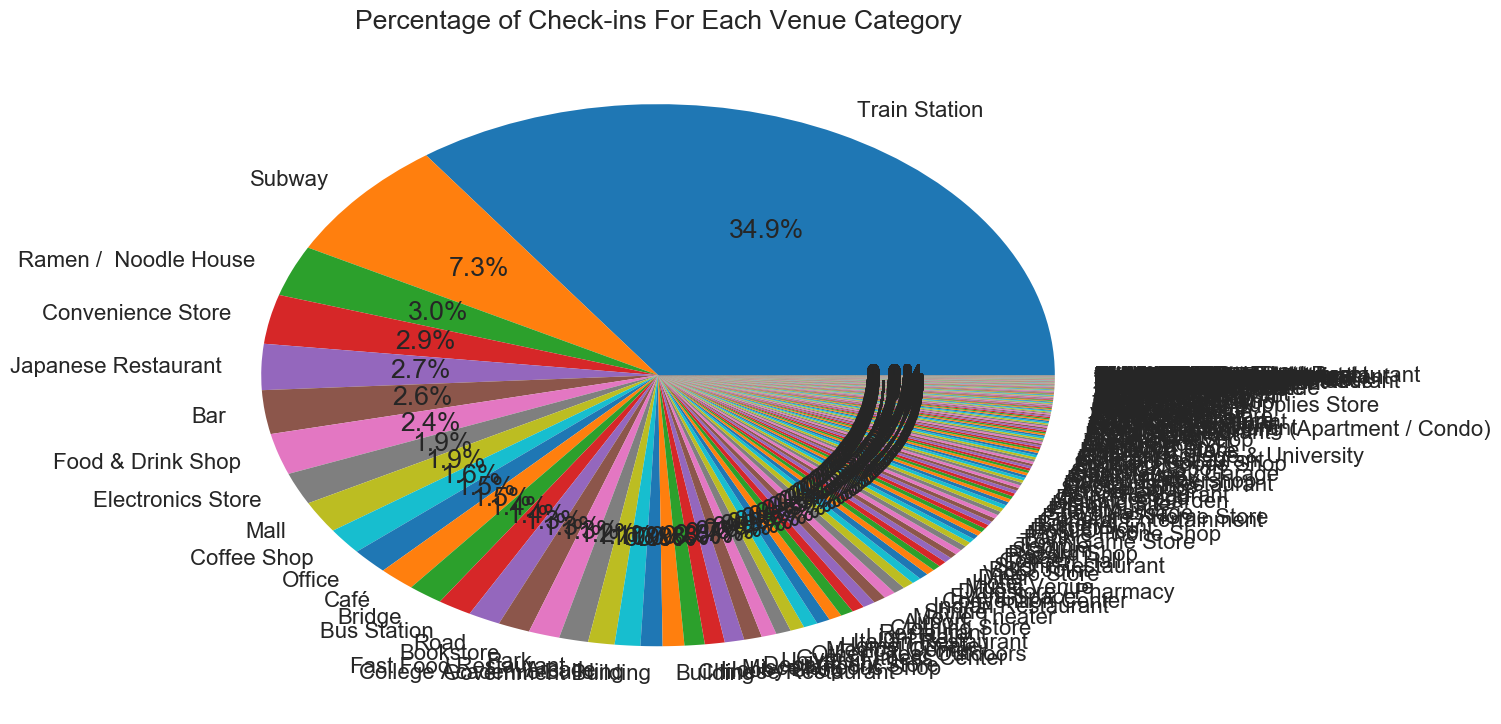

In [11]:
# Draw a pie chart showing the relative counts for each main category.
postersettings()

counts_venuecat = df.venuecat.value_counts()

plt.pie(counts_venuecat, labels = counts_venuecat.index, autopct = '%1.1f%%')
plt.title('Percentage of Check-ins For Each Venue Category')
plt.show()

The distribution of check-ins shows almost half of all check-ins belonging to Travel & Transport. This is not surprising, as trains and subways are the preferred modes of transportation around Tokyo. After Travel & Transport, the next two most popular venue categories are Shop & Service and Food. The rest of the venue categories occupy slimmer slices of the overall pie.

The abundance of Travel & Transport check-ins introduces imbalance in this data set, which will make task of multiclass classification challenging. As a result, careful feature selection and feature engineering will be crucial in giving our classifiers the best chance to discriminate among the many venue categories.

Let's see what kind of information we can gather through continued visualization of each venue category.

### Show weekly check-ins by main venue category

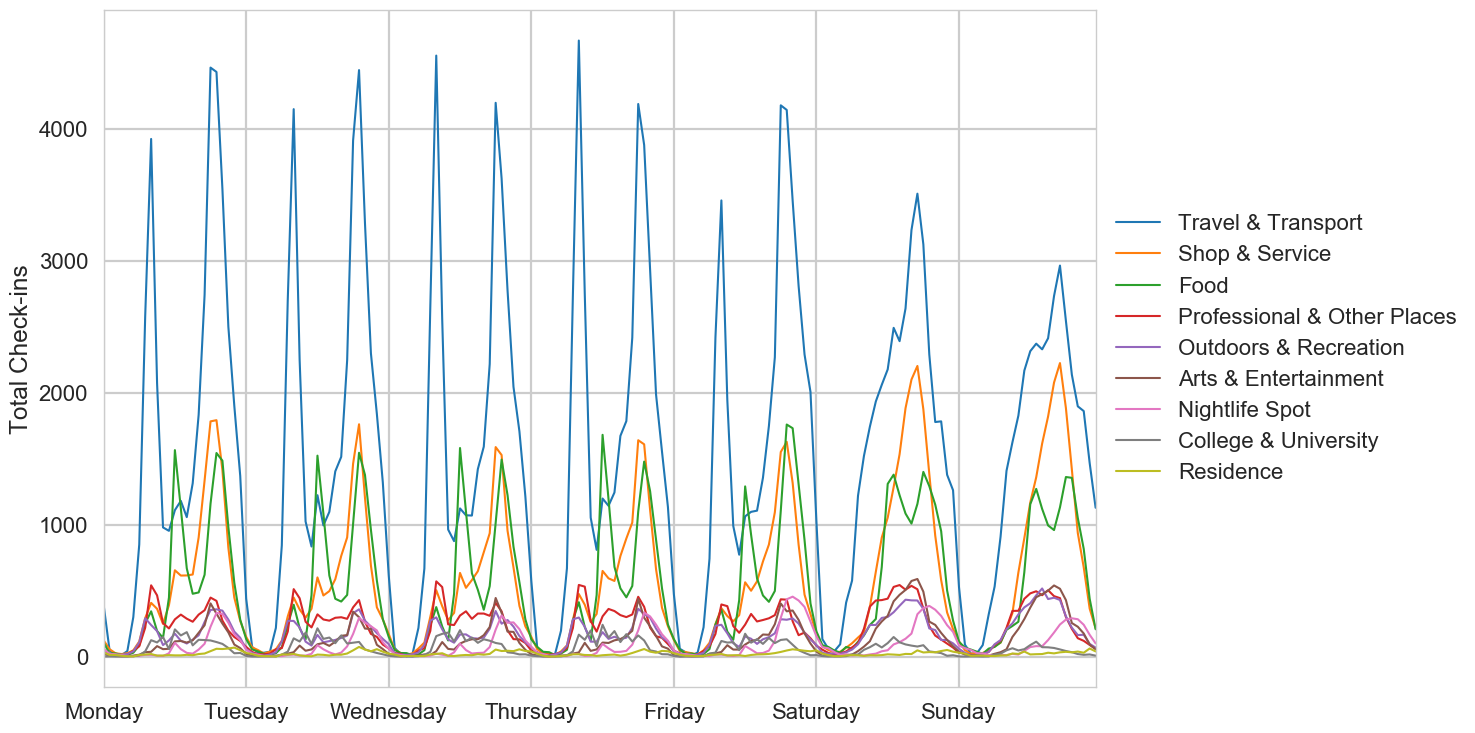

In [12]:
postersettings()

maincats = np.arange(len(counts_maincat))

for maincat in maincats:
    df_checkins_by_hour = pd.DataFrame(df[df.maincat_encoded == maincat].resample('H').count().userid)
    df_checkins_by_hour['hour'] = df_checkins_by_hour.index.hour
    df_checkins_by_hour['weekday'] = df_checkins_by_hour.index.weekday
    df_checkins_by_hour.groupby(['weekday', 'hour']).sum().userid.plot(linewidth = 1.5)
    
plt.xlabel('')
plt.ylabel('Total Check-ins')
plt.legend(counts_maincat.index, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xticks(np.arange(0, 7*24, 24), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
    
plt.show()

Travel & Transport
 - Strong peaks during morning and evening commutes with a small bump during lunchtime.
     - Heavy out of necessity
 - Weekdays show a different signature compared to weekends.
 - Check-ins during weekdays drop off a bit on Friday.
 
Shop & Service
 - Shopping peaks during morning commute, lunchtime, and dinnertime. Clearly strongest at dinnertime.
 - More by ~33% from weekdays to weekends

Food
 - A lot of people skip breakfast (or eat at home) and just eat lunch and dinner
 
Professional & Other Places
 - Peaks with morning commute, lunchtime, and evening commute. Are these workers?
 
Outdoors & Recreation
 - Peaks with breakfast, lunch, and dinner during weekdays
 - One large peak for Saturday and Sunday
 
Arts & Entertainment
 - Peaks during dinnertime weekdays, single peak for both weekend days
 
Nightlife Spot
 - Peaks during noon, highest during dinner on weekdays
 - Friday has most check-ins followed by Saturday
 - One peak for Saturday and Sunday

College & University
 - Peaks every ~2 hours. Users check-in in between classes?
 - Peaks ~7am, drops ~7pm

Residence
 - Mostly during evenings.

### Show weekly check-ins for Train Station, Subway, and all others

In [13]:
df["y0"] = 2
df.loc[df.venuecat_encoded == 0, "y0"] = 0
df.loc[df.venuecat_encoded == 1, "y0"] = 1

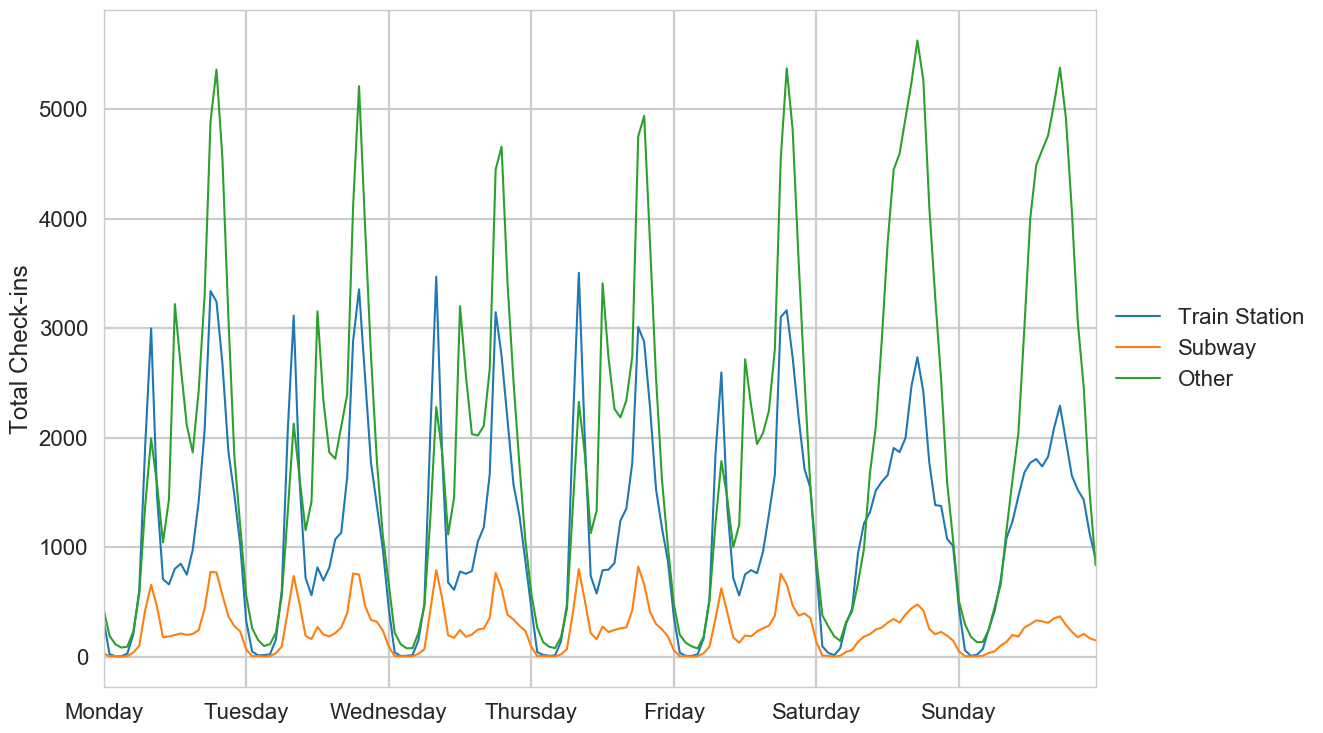

In [14]:
postersettings()

y0s = np.arange(3)

for y0 in y0s:
    df_checkins_by_hour = pd.DataFrame(df[df["y0"] == y0].resample('H').count().userid)
    df_checkins_by_hour['hour'] = df_checkins_by_hour.index.hour
    df_checkins_by_hour['weekday'] = df_checkins_by_hour.index.weekday
    df_checkins_by_hour.groupby(['weekday', 'hour']).sum().userid.plot(linewidth = 1.5)
    
plt.xlabel('')
plt.ylabel('Total Check-ins')
plt.legend(["Train Station", "Subway", "Other"], loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xticks(np.arange(0, 7*24, 24), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
    
plt.show()

### User-specific weekly check-ins

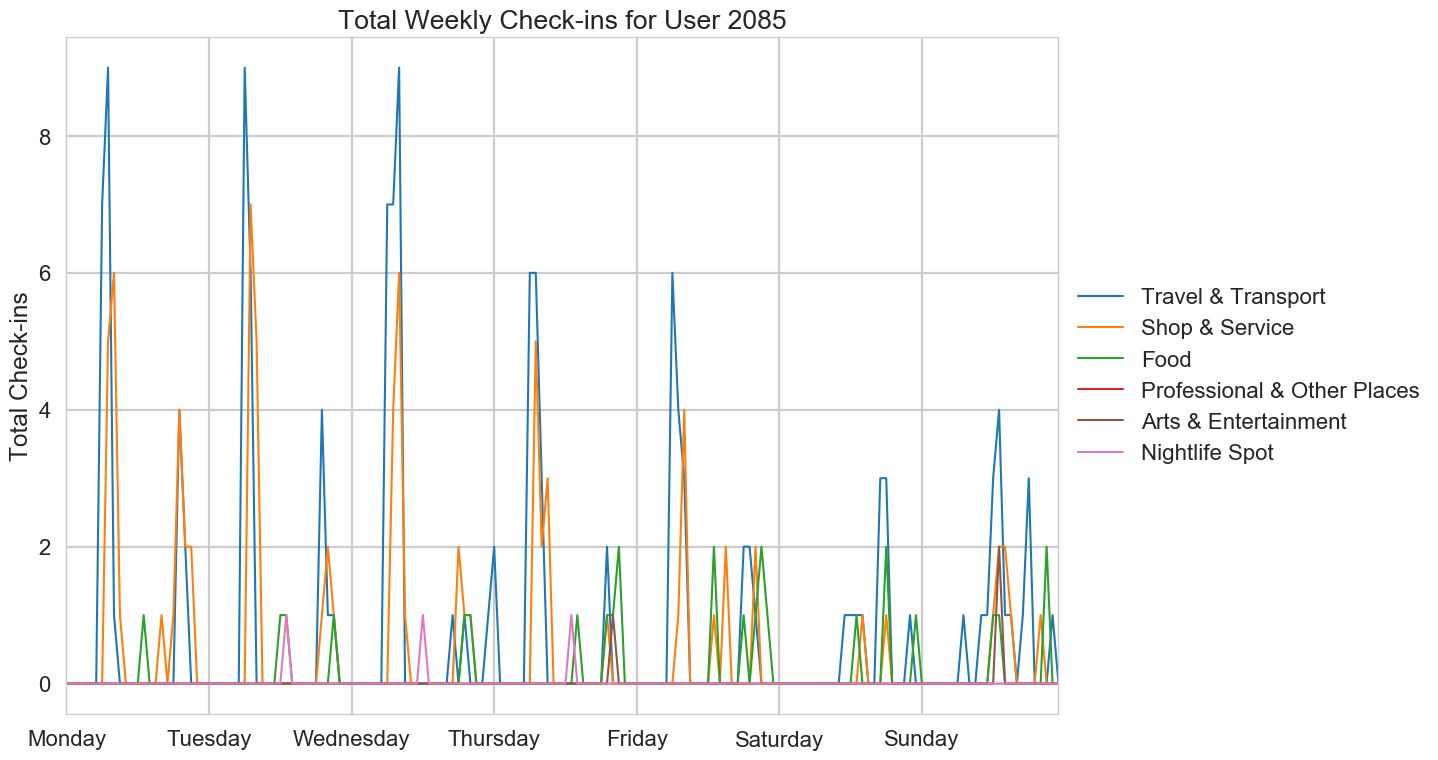

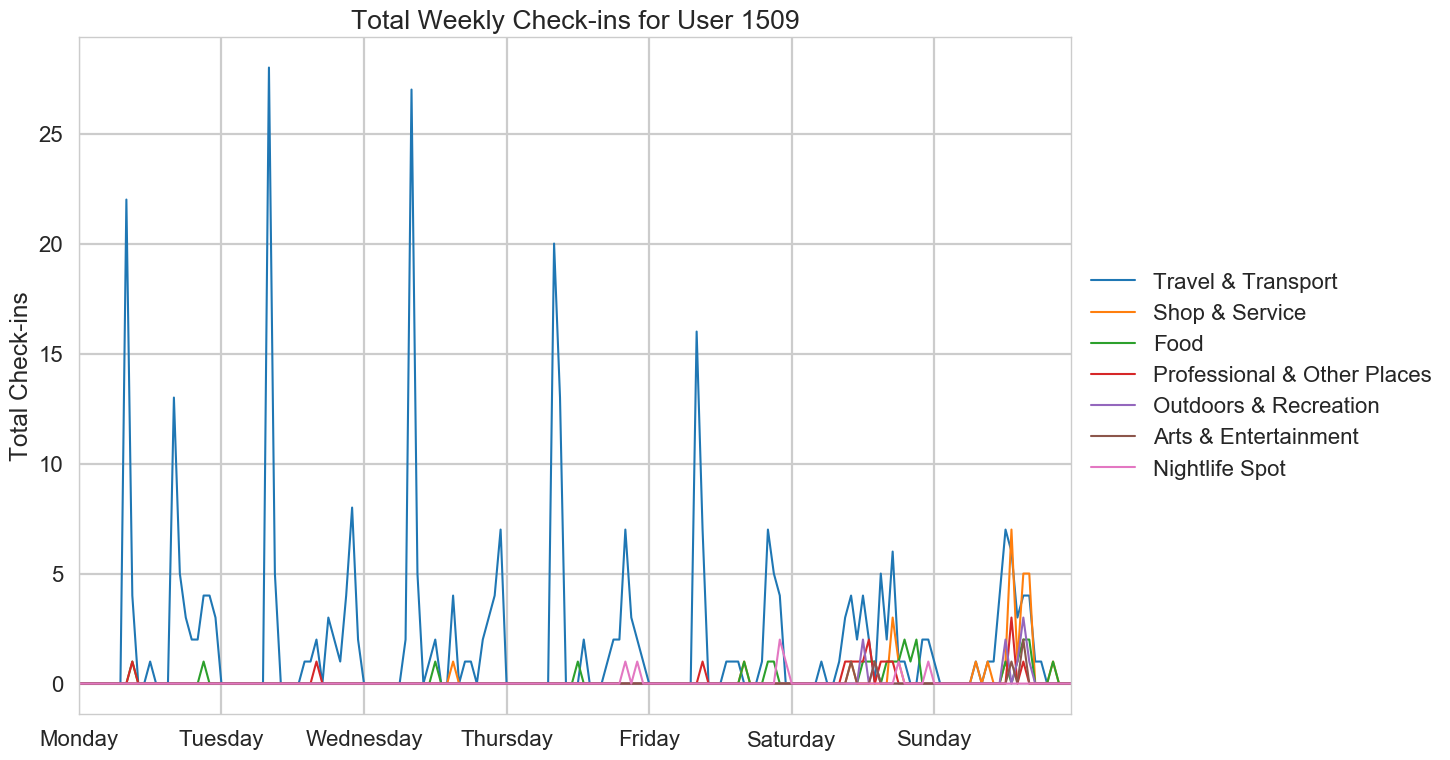

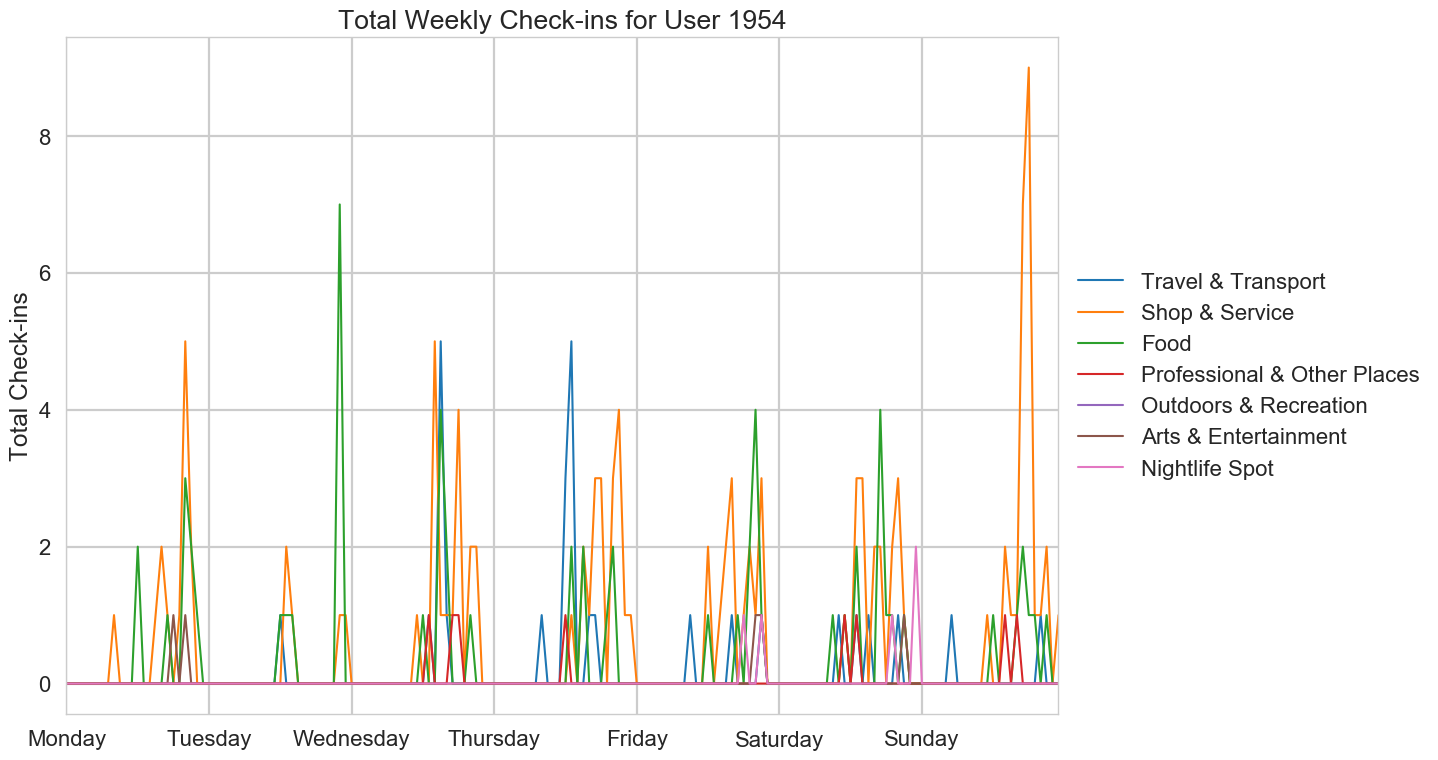

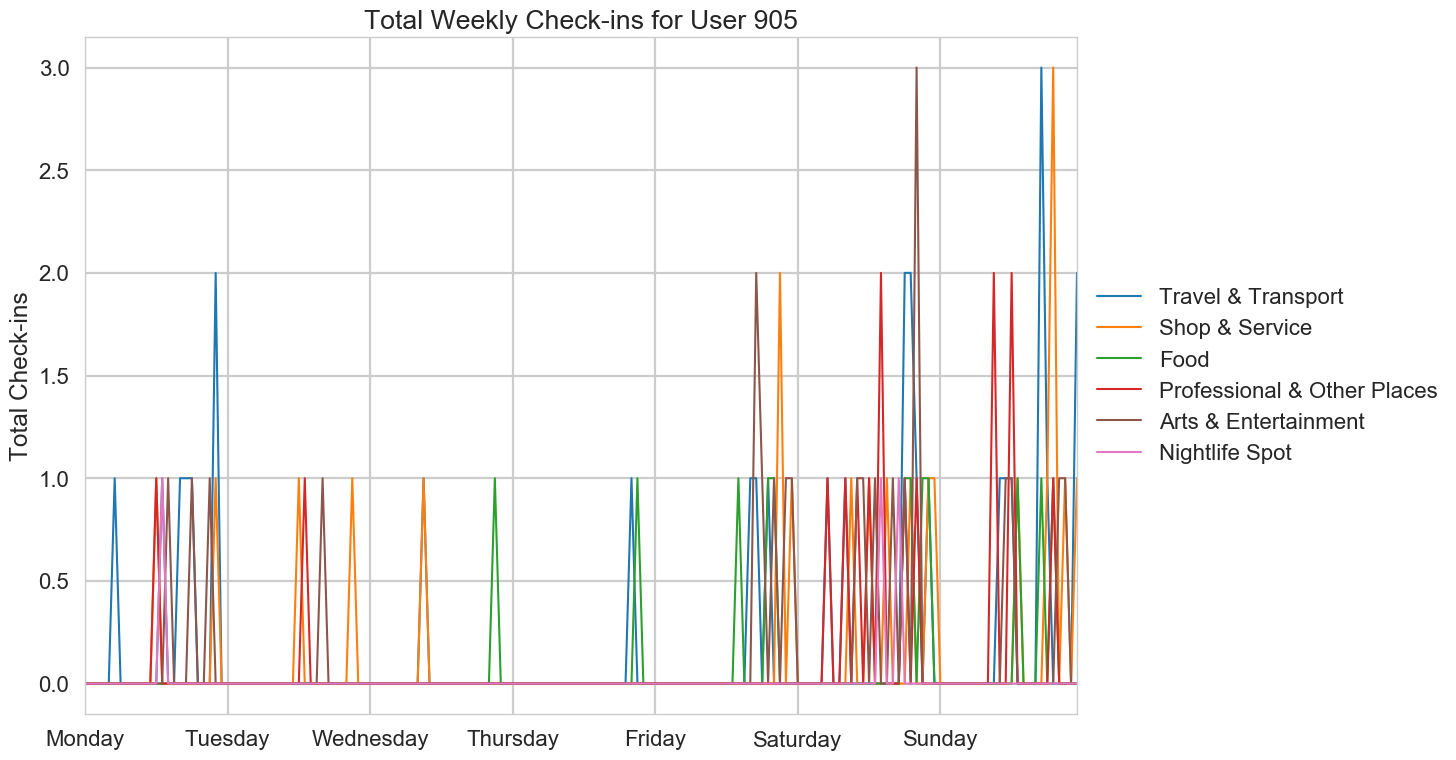

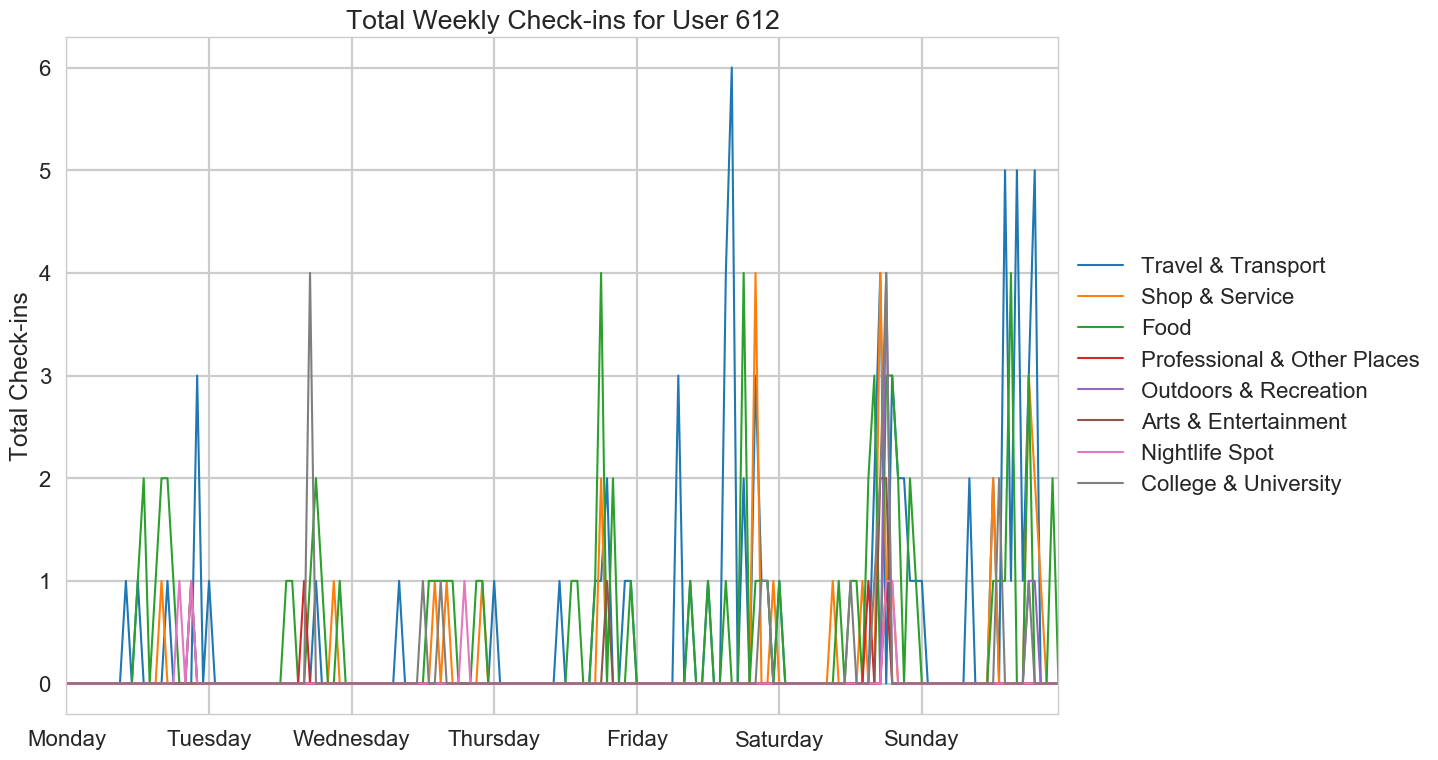

In [15]:
postersettings()

sample_userids = np.random.randint(df.userid.max(), size = 5)

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

for sample_userid in sample_userids:
    
    df_sample_userid = df[df.userid == int(sample_userid)]
    maincat_indices = df_sample_userid.maincat_encoded.value_counts().index.sort_values()
    maincatnames = counts_maincat.index[maincat_indices]
    
    plt.figure()
    plt.gca().set_prop_cycle(color = [palette[index] for index in maincat_indices])

    for index in maincat_indices:
        
        df_sample_userid_by_hour = pd.DataFrame(df_sample_userid[df_sample_userid.maincat_encoded == index].resample('H').count().userid)

        if df_sample_userid_by_hour.shape[0]:
            
            df_sample_userid_by_hour['hour'] = df_sample_userid_by_hour.index.hour
            df_sample_userid_by_hour['weekday'] = df_sample_userid_by_hour.index.weekday
            df_sample_userid_by_hour.groupby(['weekday', 'hour']).sum().userid.plot(linewidth = 1.5)
    
    plt.xlabel('')
    plt.ylabel('Total Check-ins')
    plt.title('Total Weekly Check-ins for User ' + str(sample_userid))
        
    plt.legend(maincatnames, loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.xticks(np.arange(0, 7*24, 24), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
    
plt.show()

### User-specific weekly check-ins for Train Station, Subway, and all others

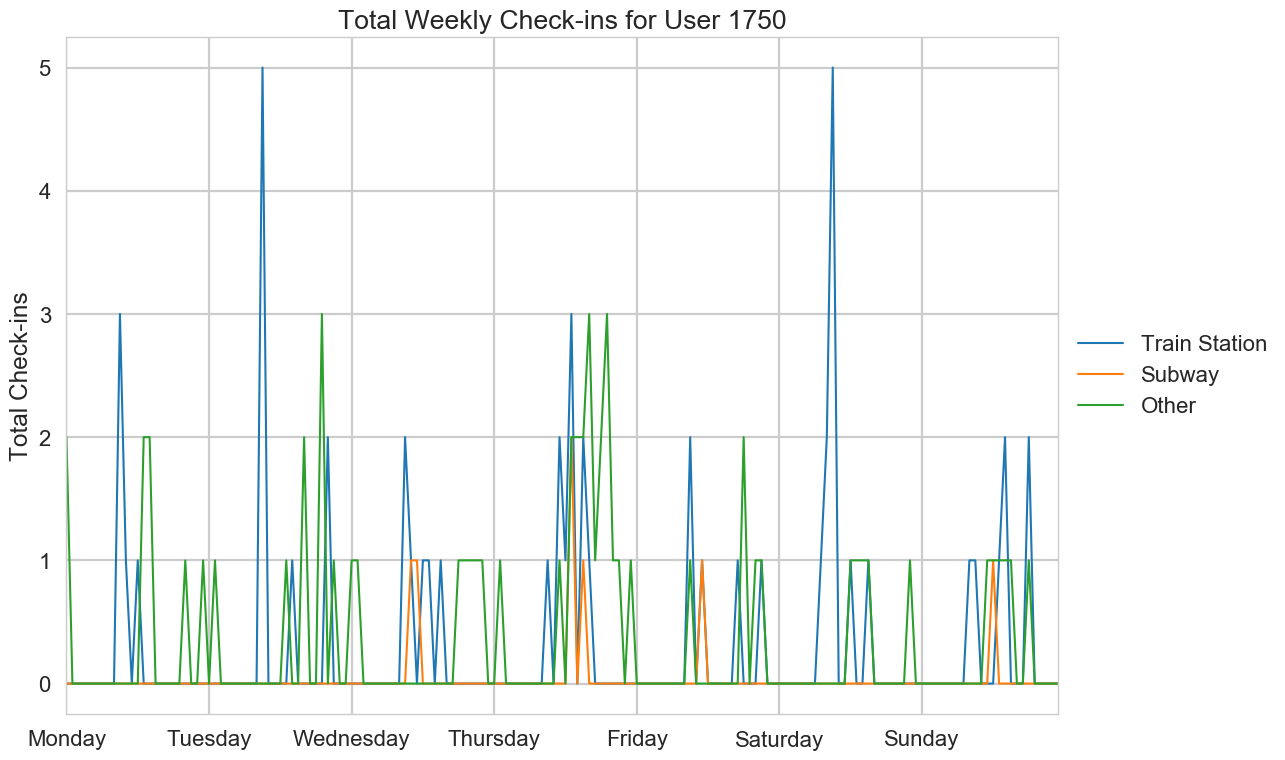

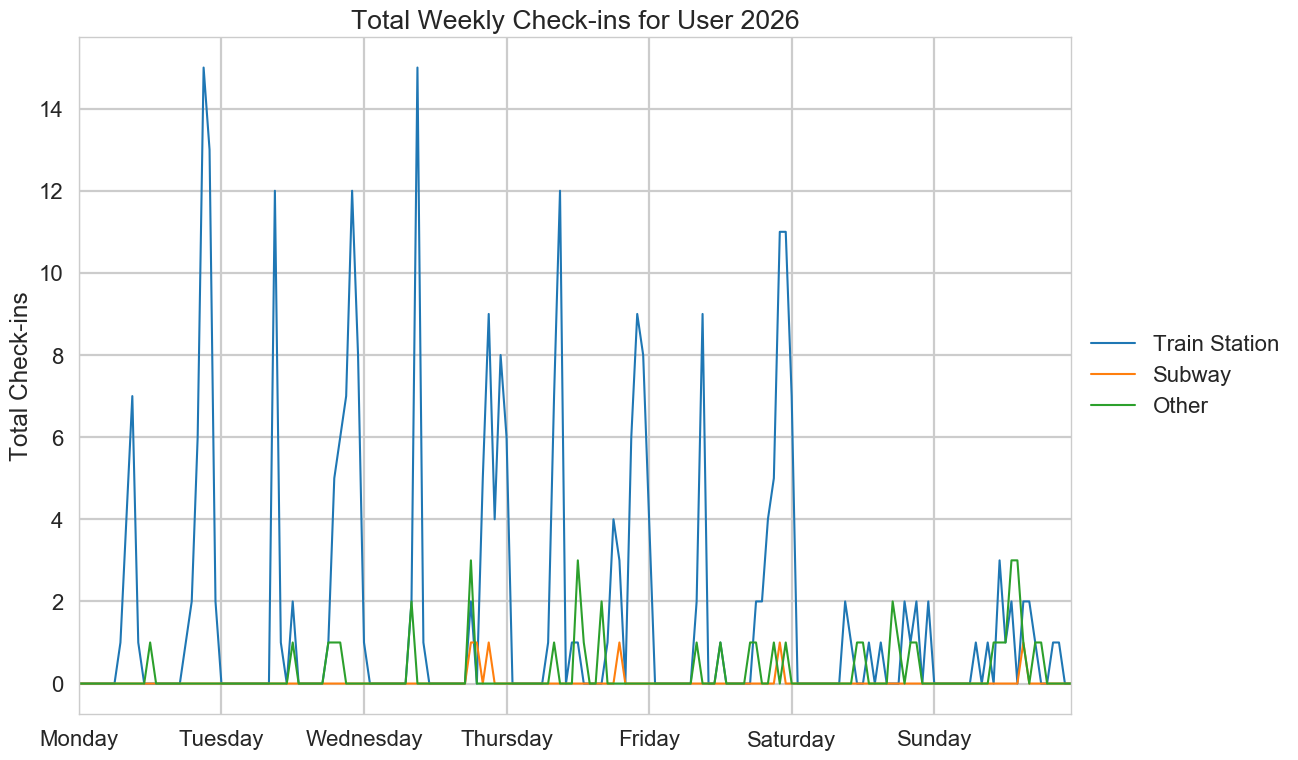

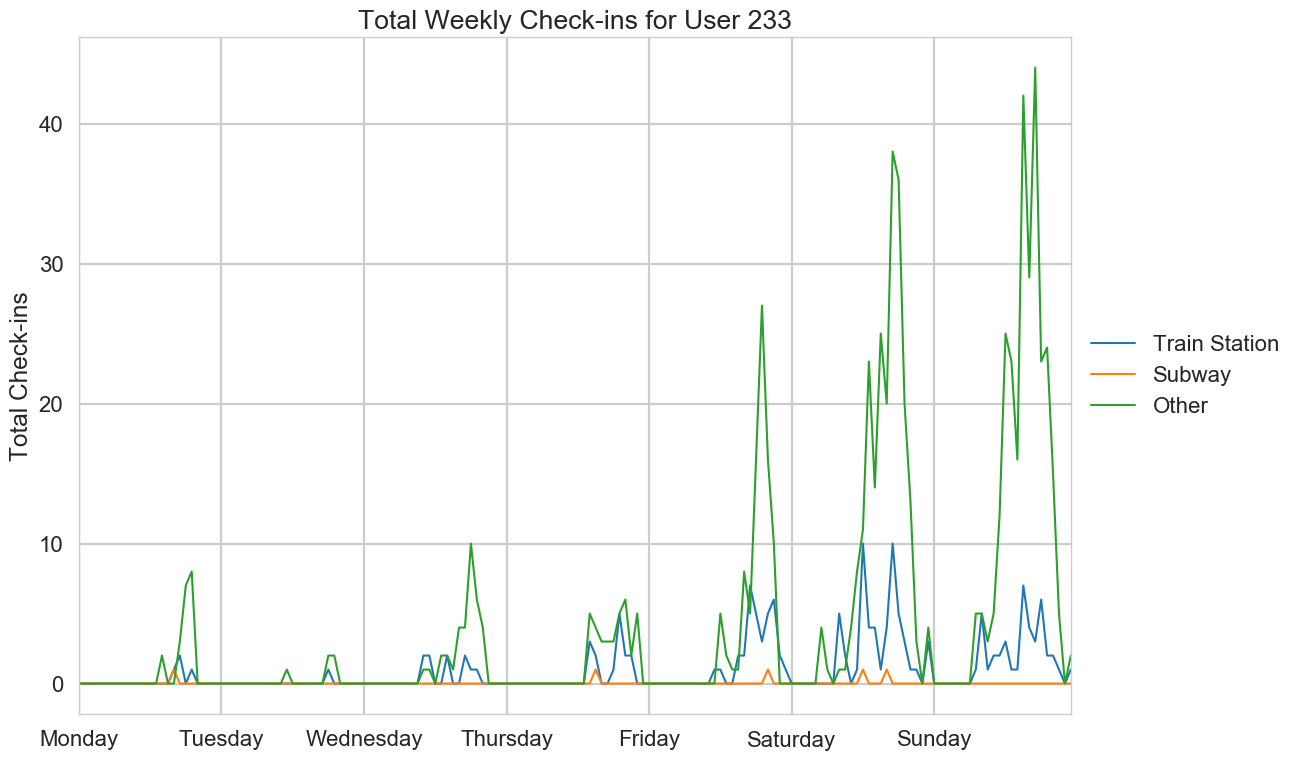

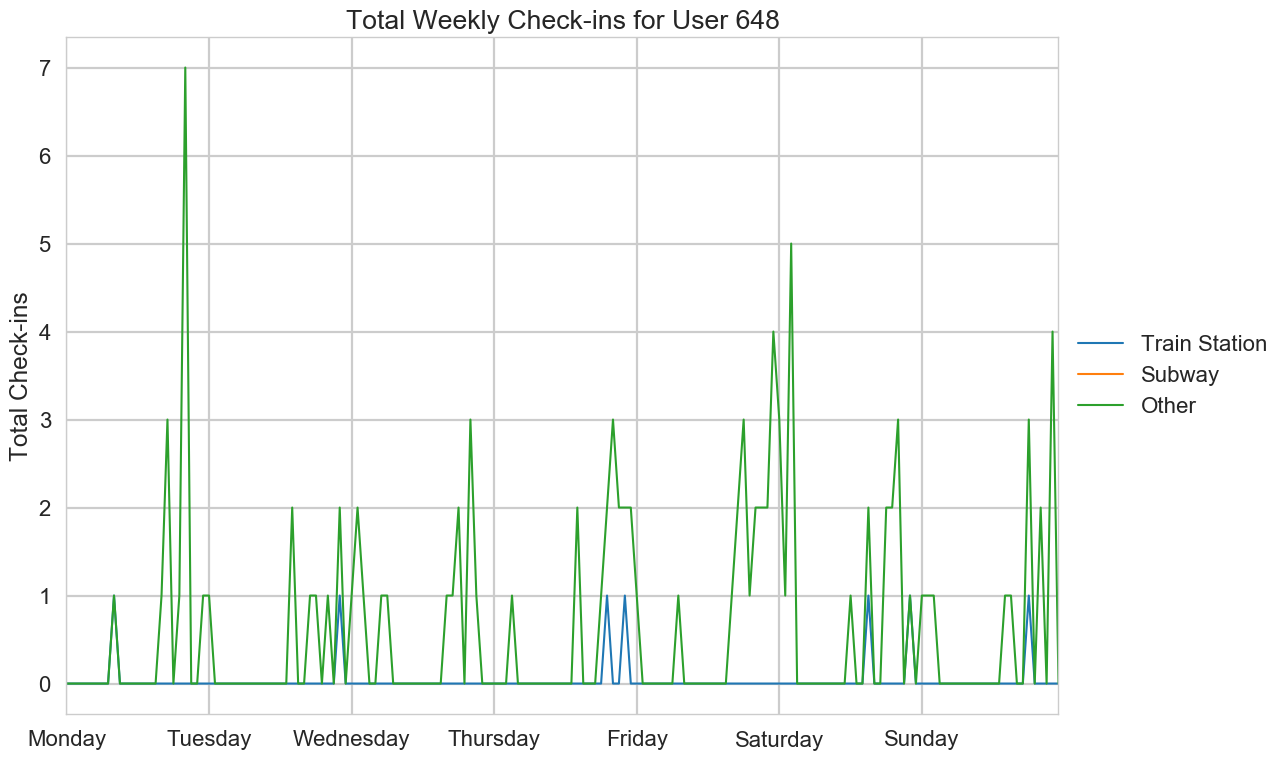

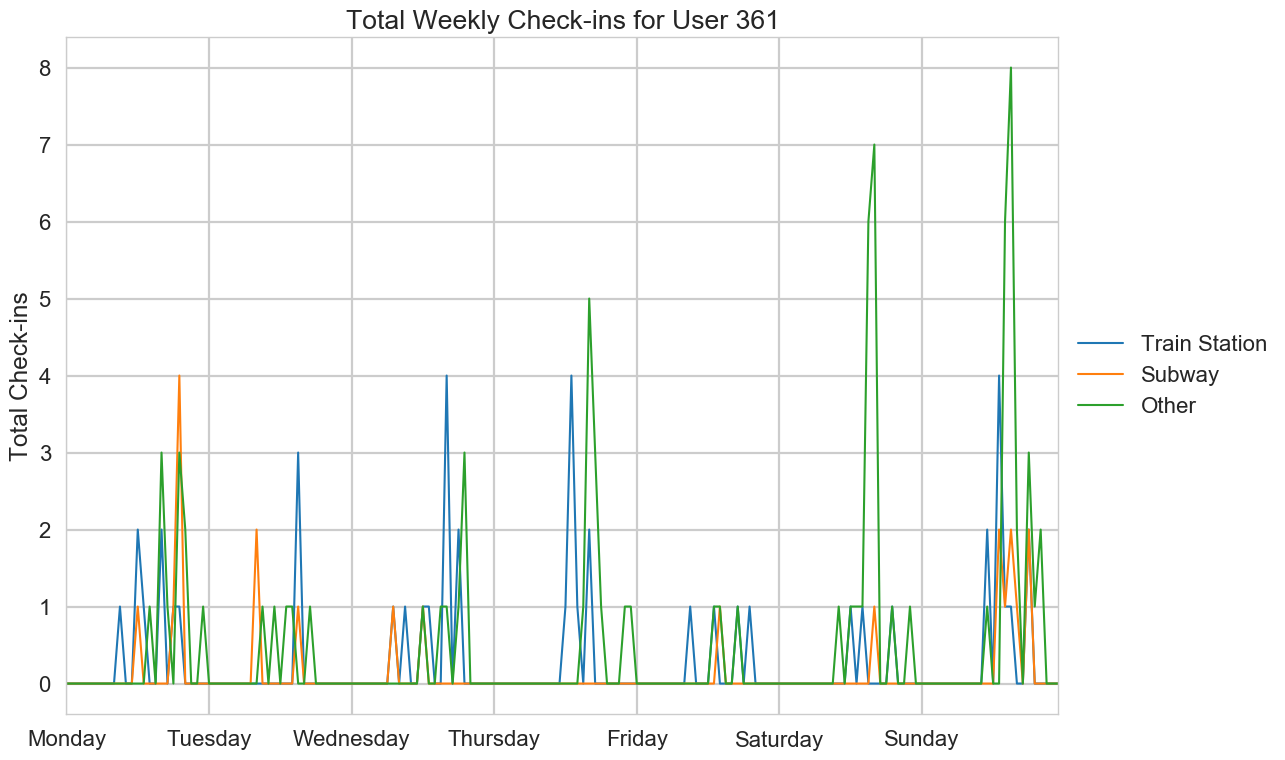

In [16]:
postersettings()

sample_userids = np.random.randint(df.userid.max(), size = 5)

for sample_userid in sample_userids:
    
    df_sample_userid = df[df.userid == int(sample_userid)]
    plt.figure()
    
    for y0 in y0s:
        
        df_sample_userid_by_hour = pd.DataFrame(df_sample_userid[df_sample_userid["y0"] == y0].resample('H').count().userid)

        if df_sample_userid_by_hour.shape[0]:
            
            df_sample_userid_by_hour['hour'] = df_sample_userid_by_hour.index.hour
            df_sample_userid_by_hour['weekday'] = df_sample_userid_by_hour.index.weekday
            df_sample_userid_by_hour.groupby(['weekday', 'hour']).sum().userid.plot(linewidth = 1.5)
    
    plt.xlabel('')
    plt.ylabel('Total Check-ins')
    plt.title('Total Weekly Check-ins for User ' + str(sample_userid))
    plt.legend(["Train Station", "Subway", "Other"], loc = 'center left', bbox_to_anchor = (1, 0.5))
    plt.xticks(np.arange(0, 7*24, 24), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
    
plt.show()

### Check-ins according to GPS coordinates for all main venue categories

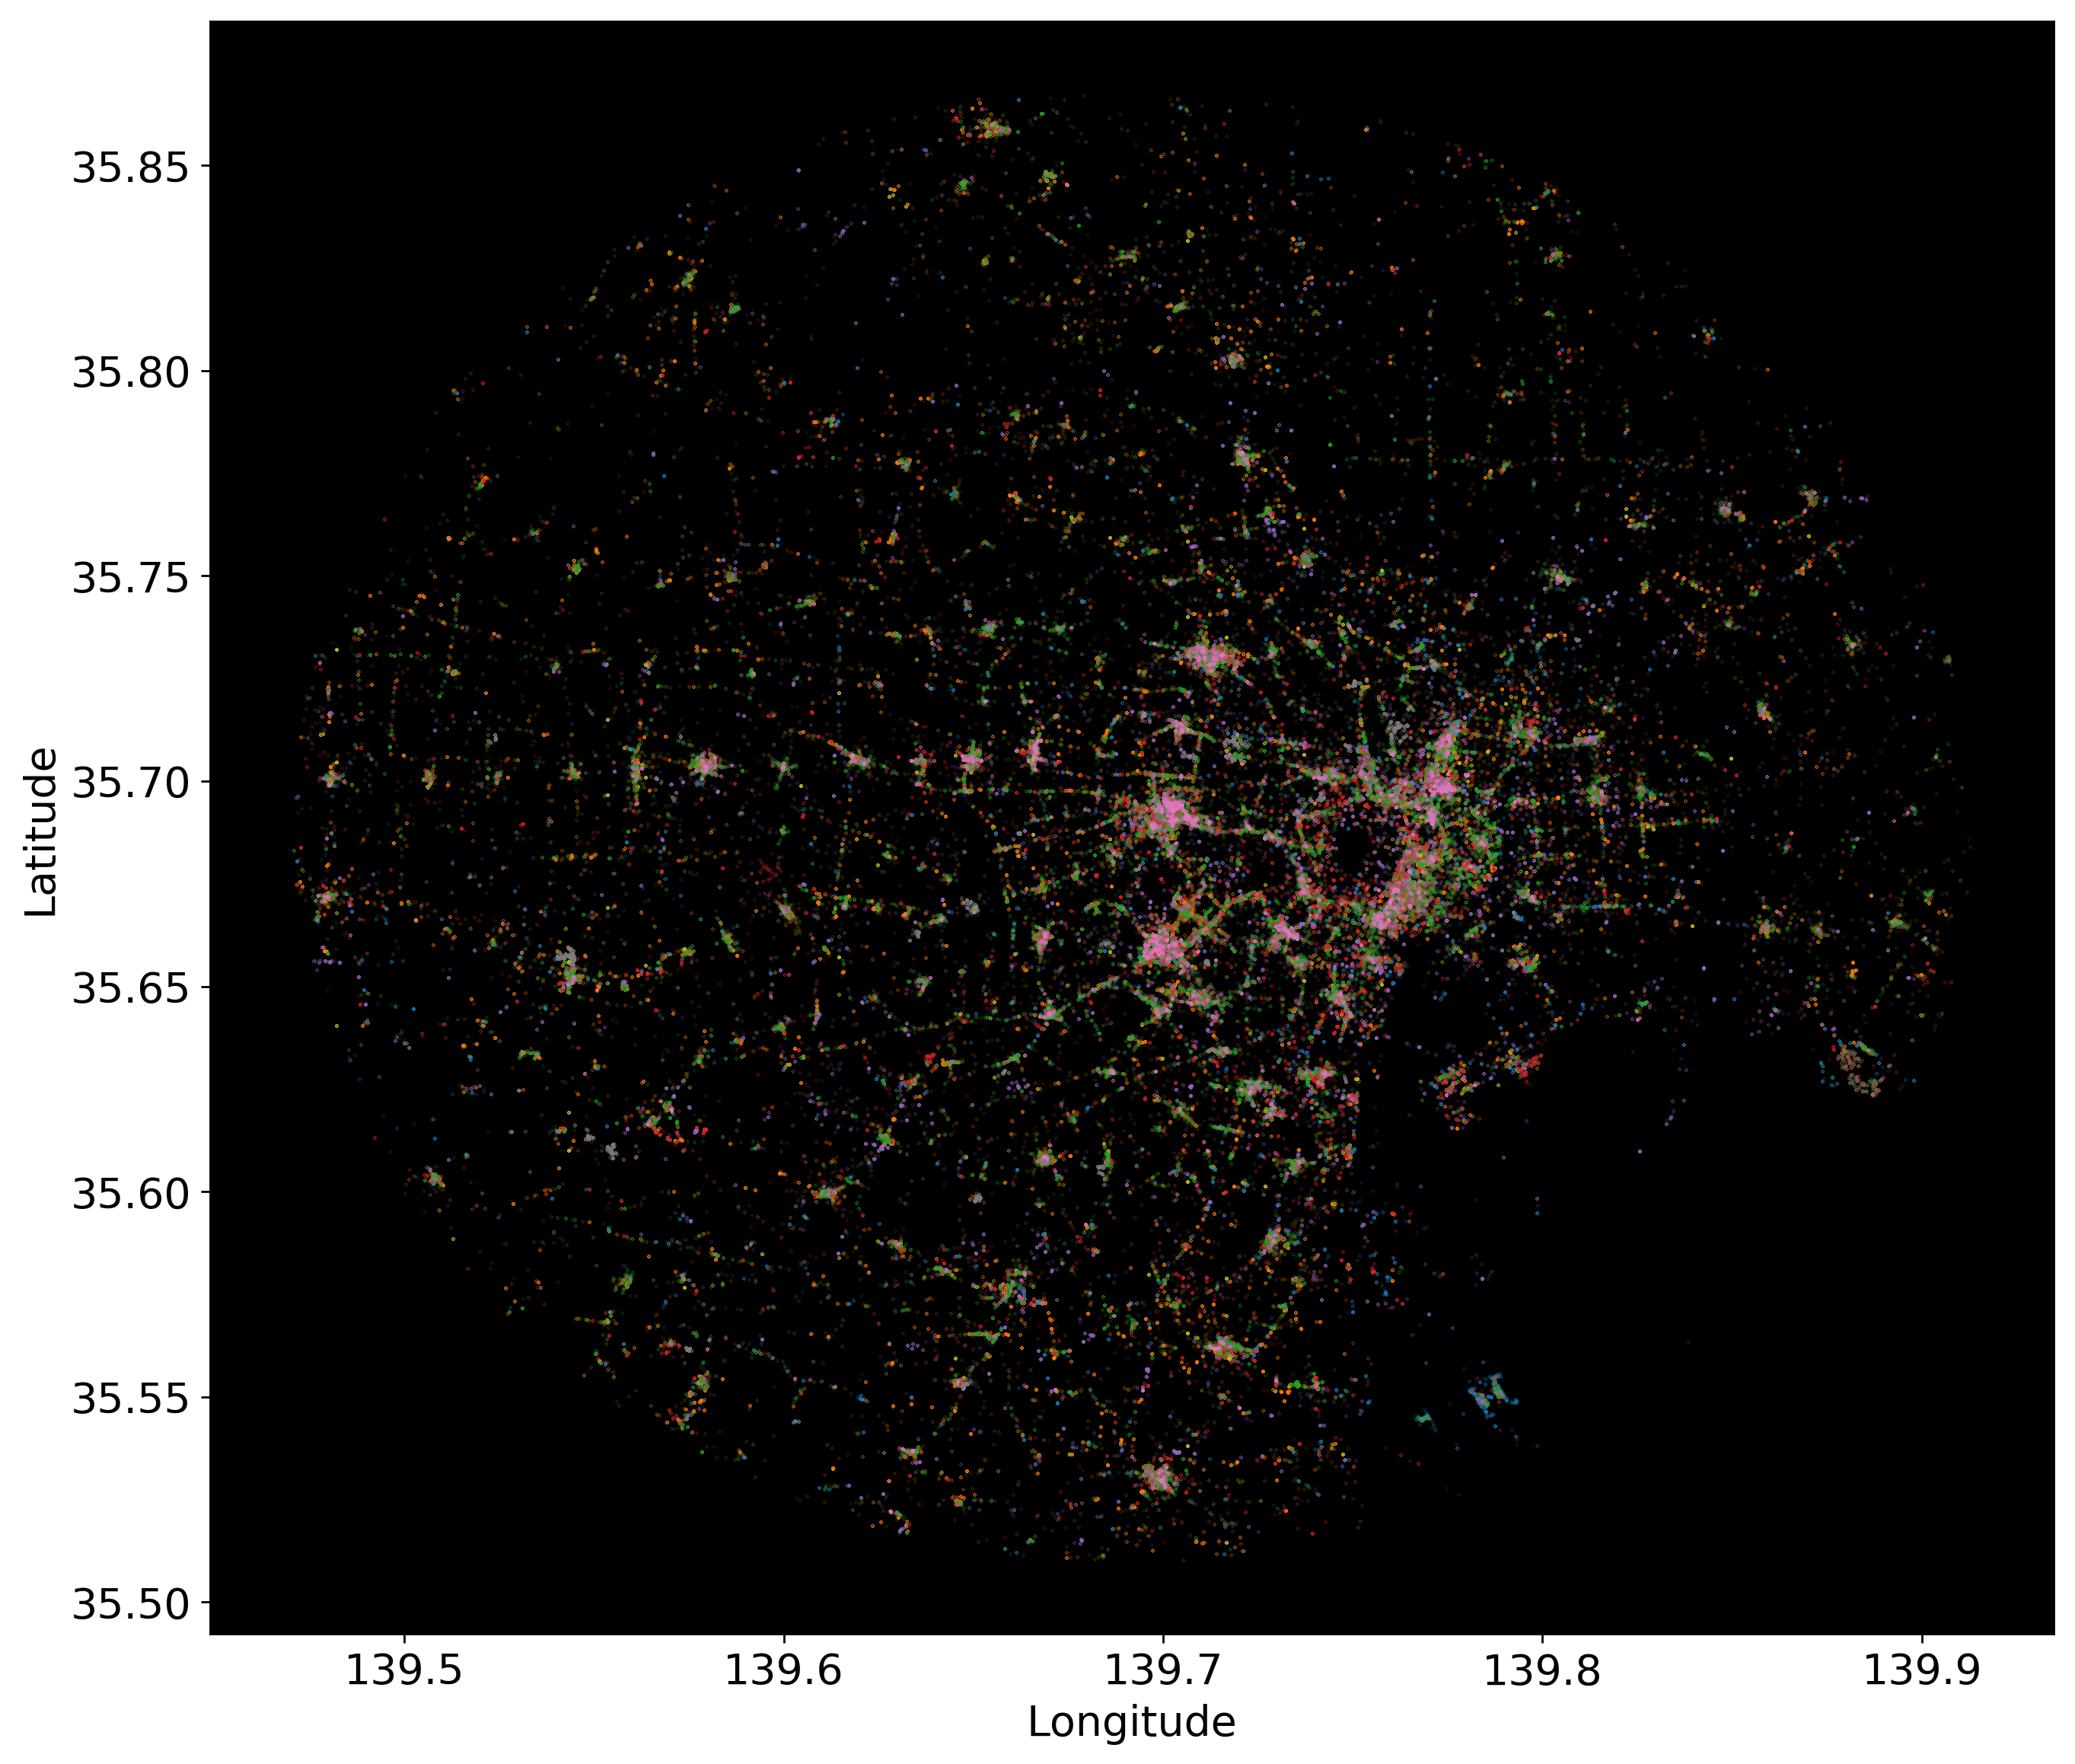

In [17]:
mapsettings(12.5,11,250)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots()

for maincat in maincats:
    df[df.maincat_encoded == maincat].plot(kind = 'scatter', x = 'long', y = 'lat', color = colors[maincat], s = 0.02, alpha = 0.6, ax = ax) 

ax.set_facecolor('black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Check-ins according to GPS coordinates for Train Station, Subway, and all others, respectively

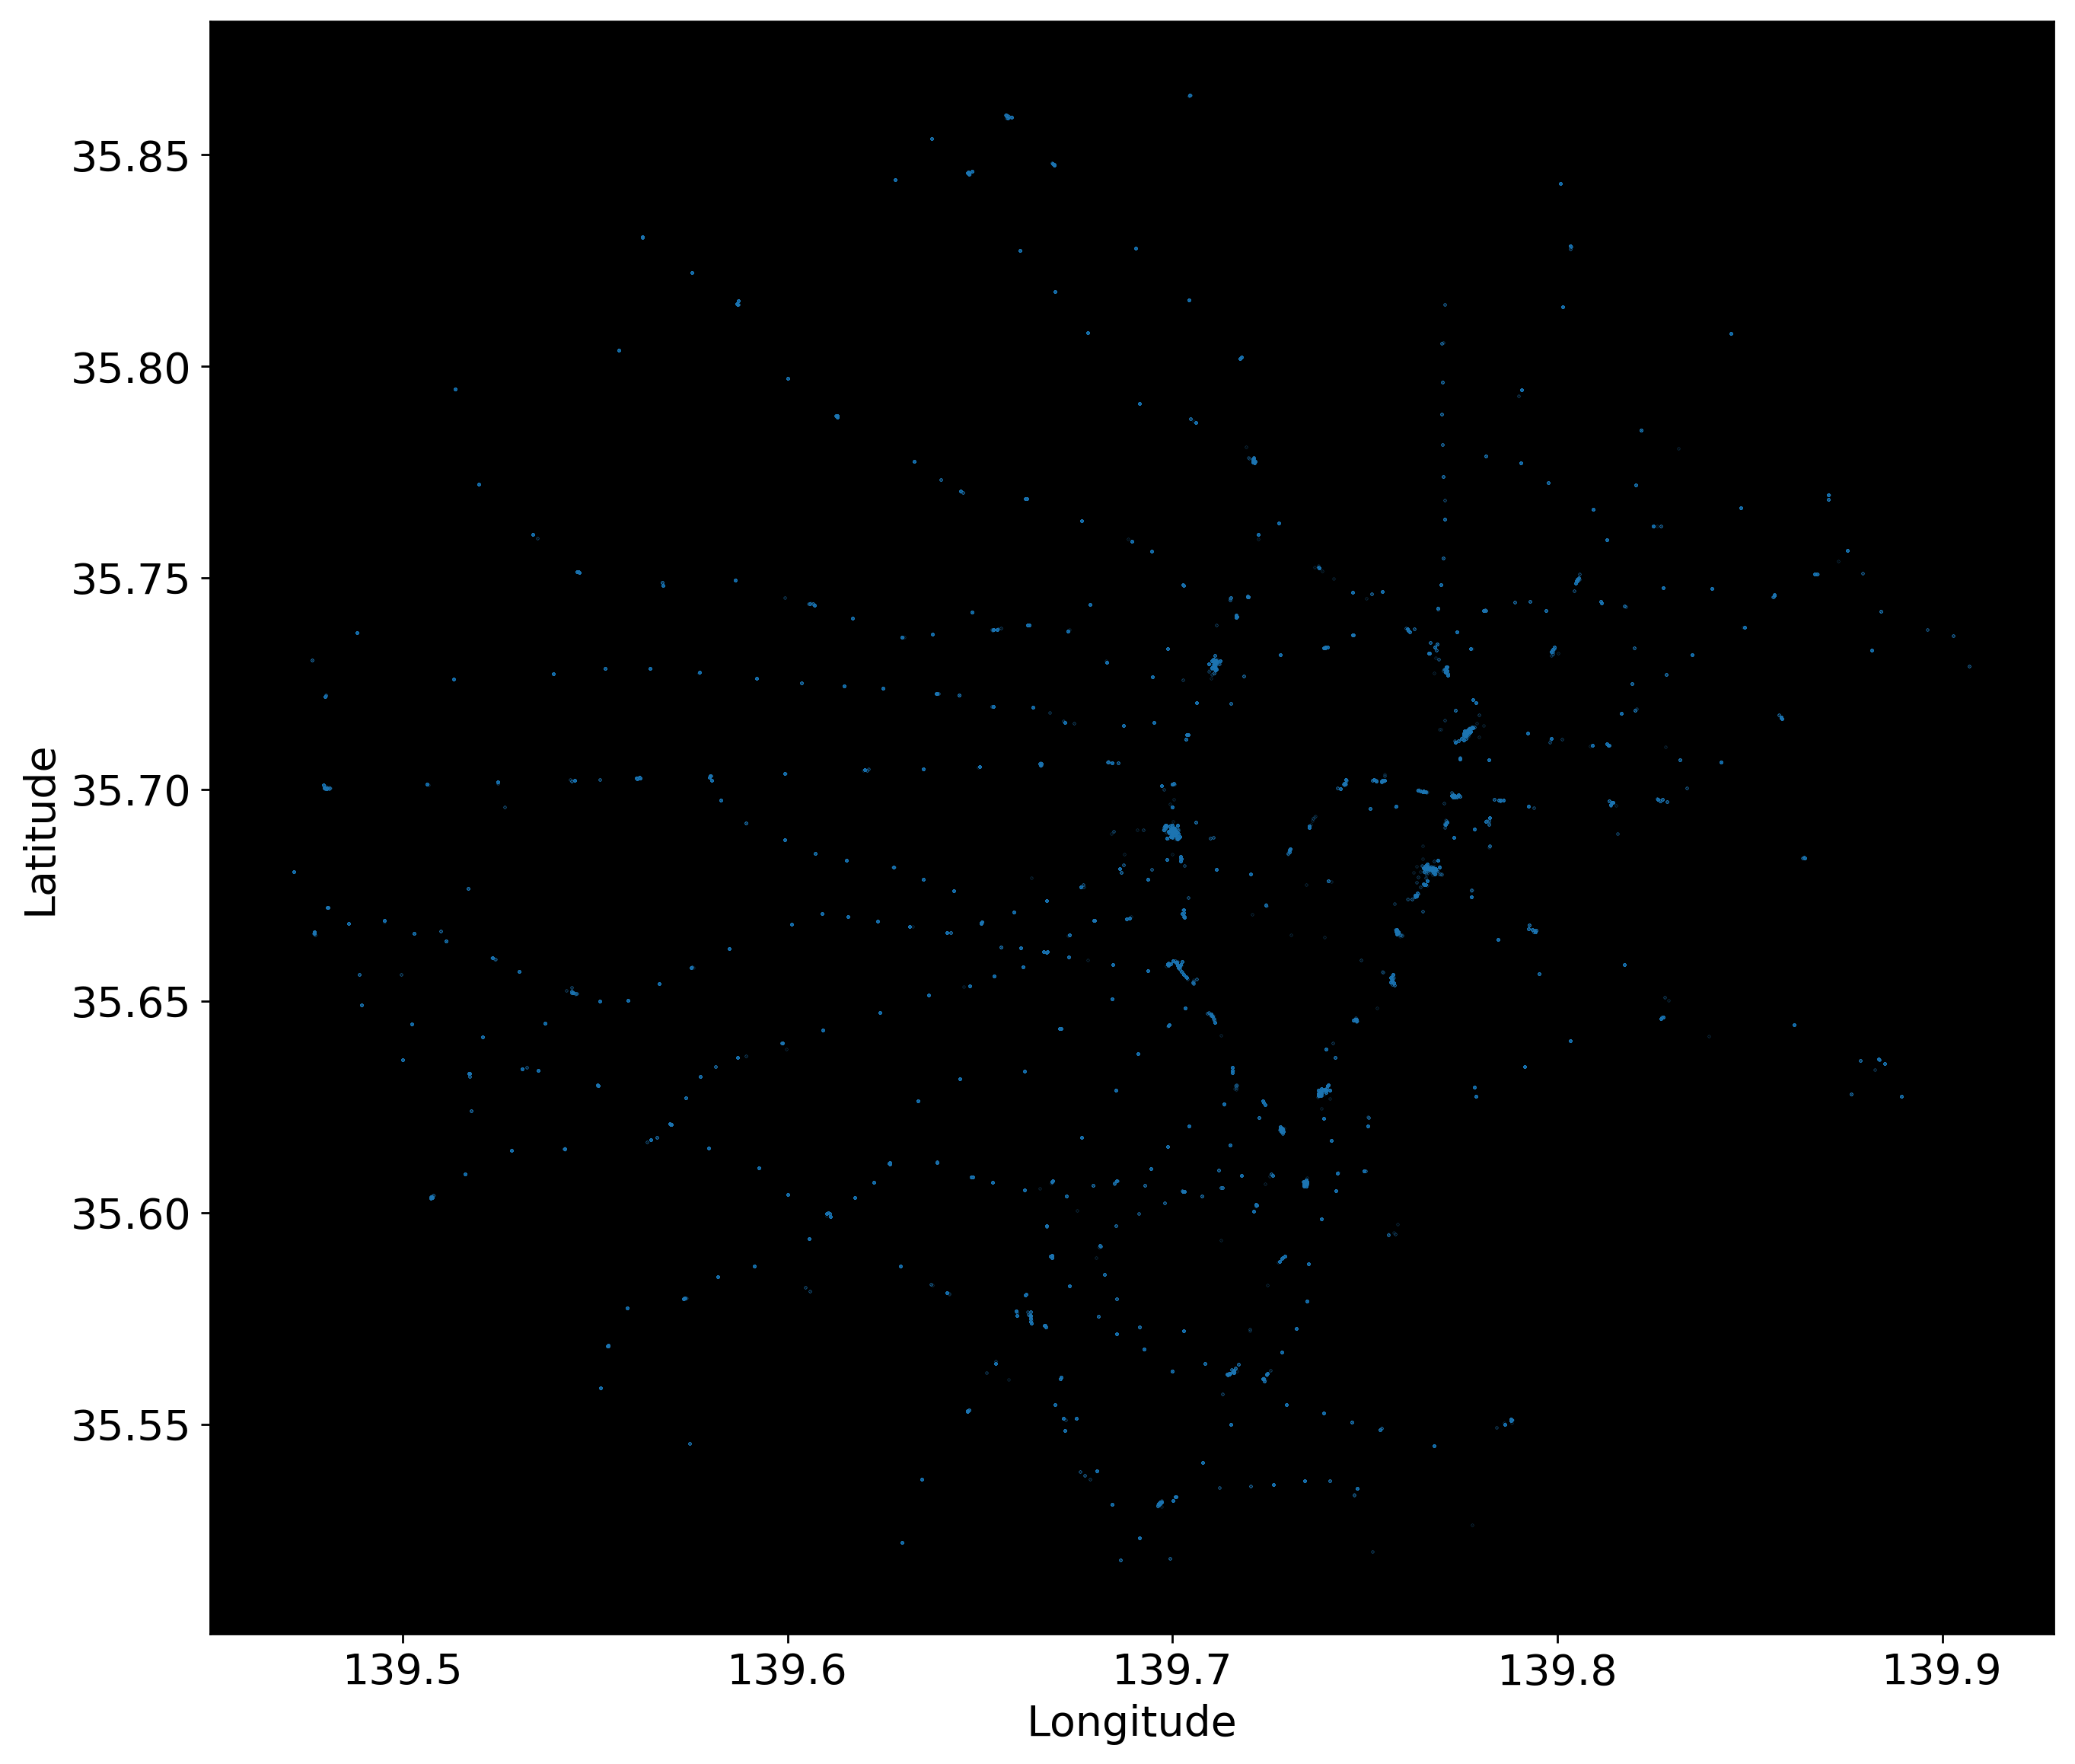

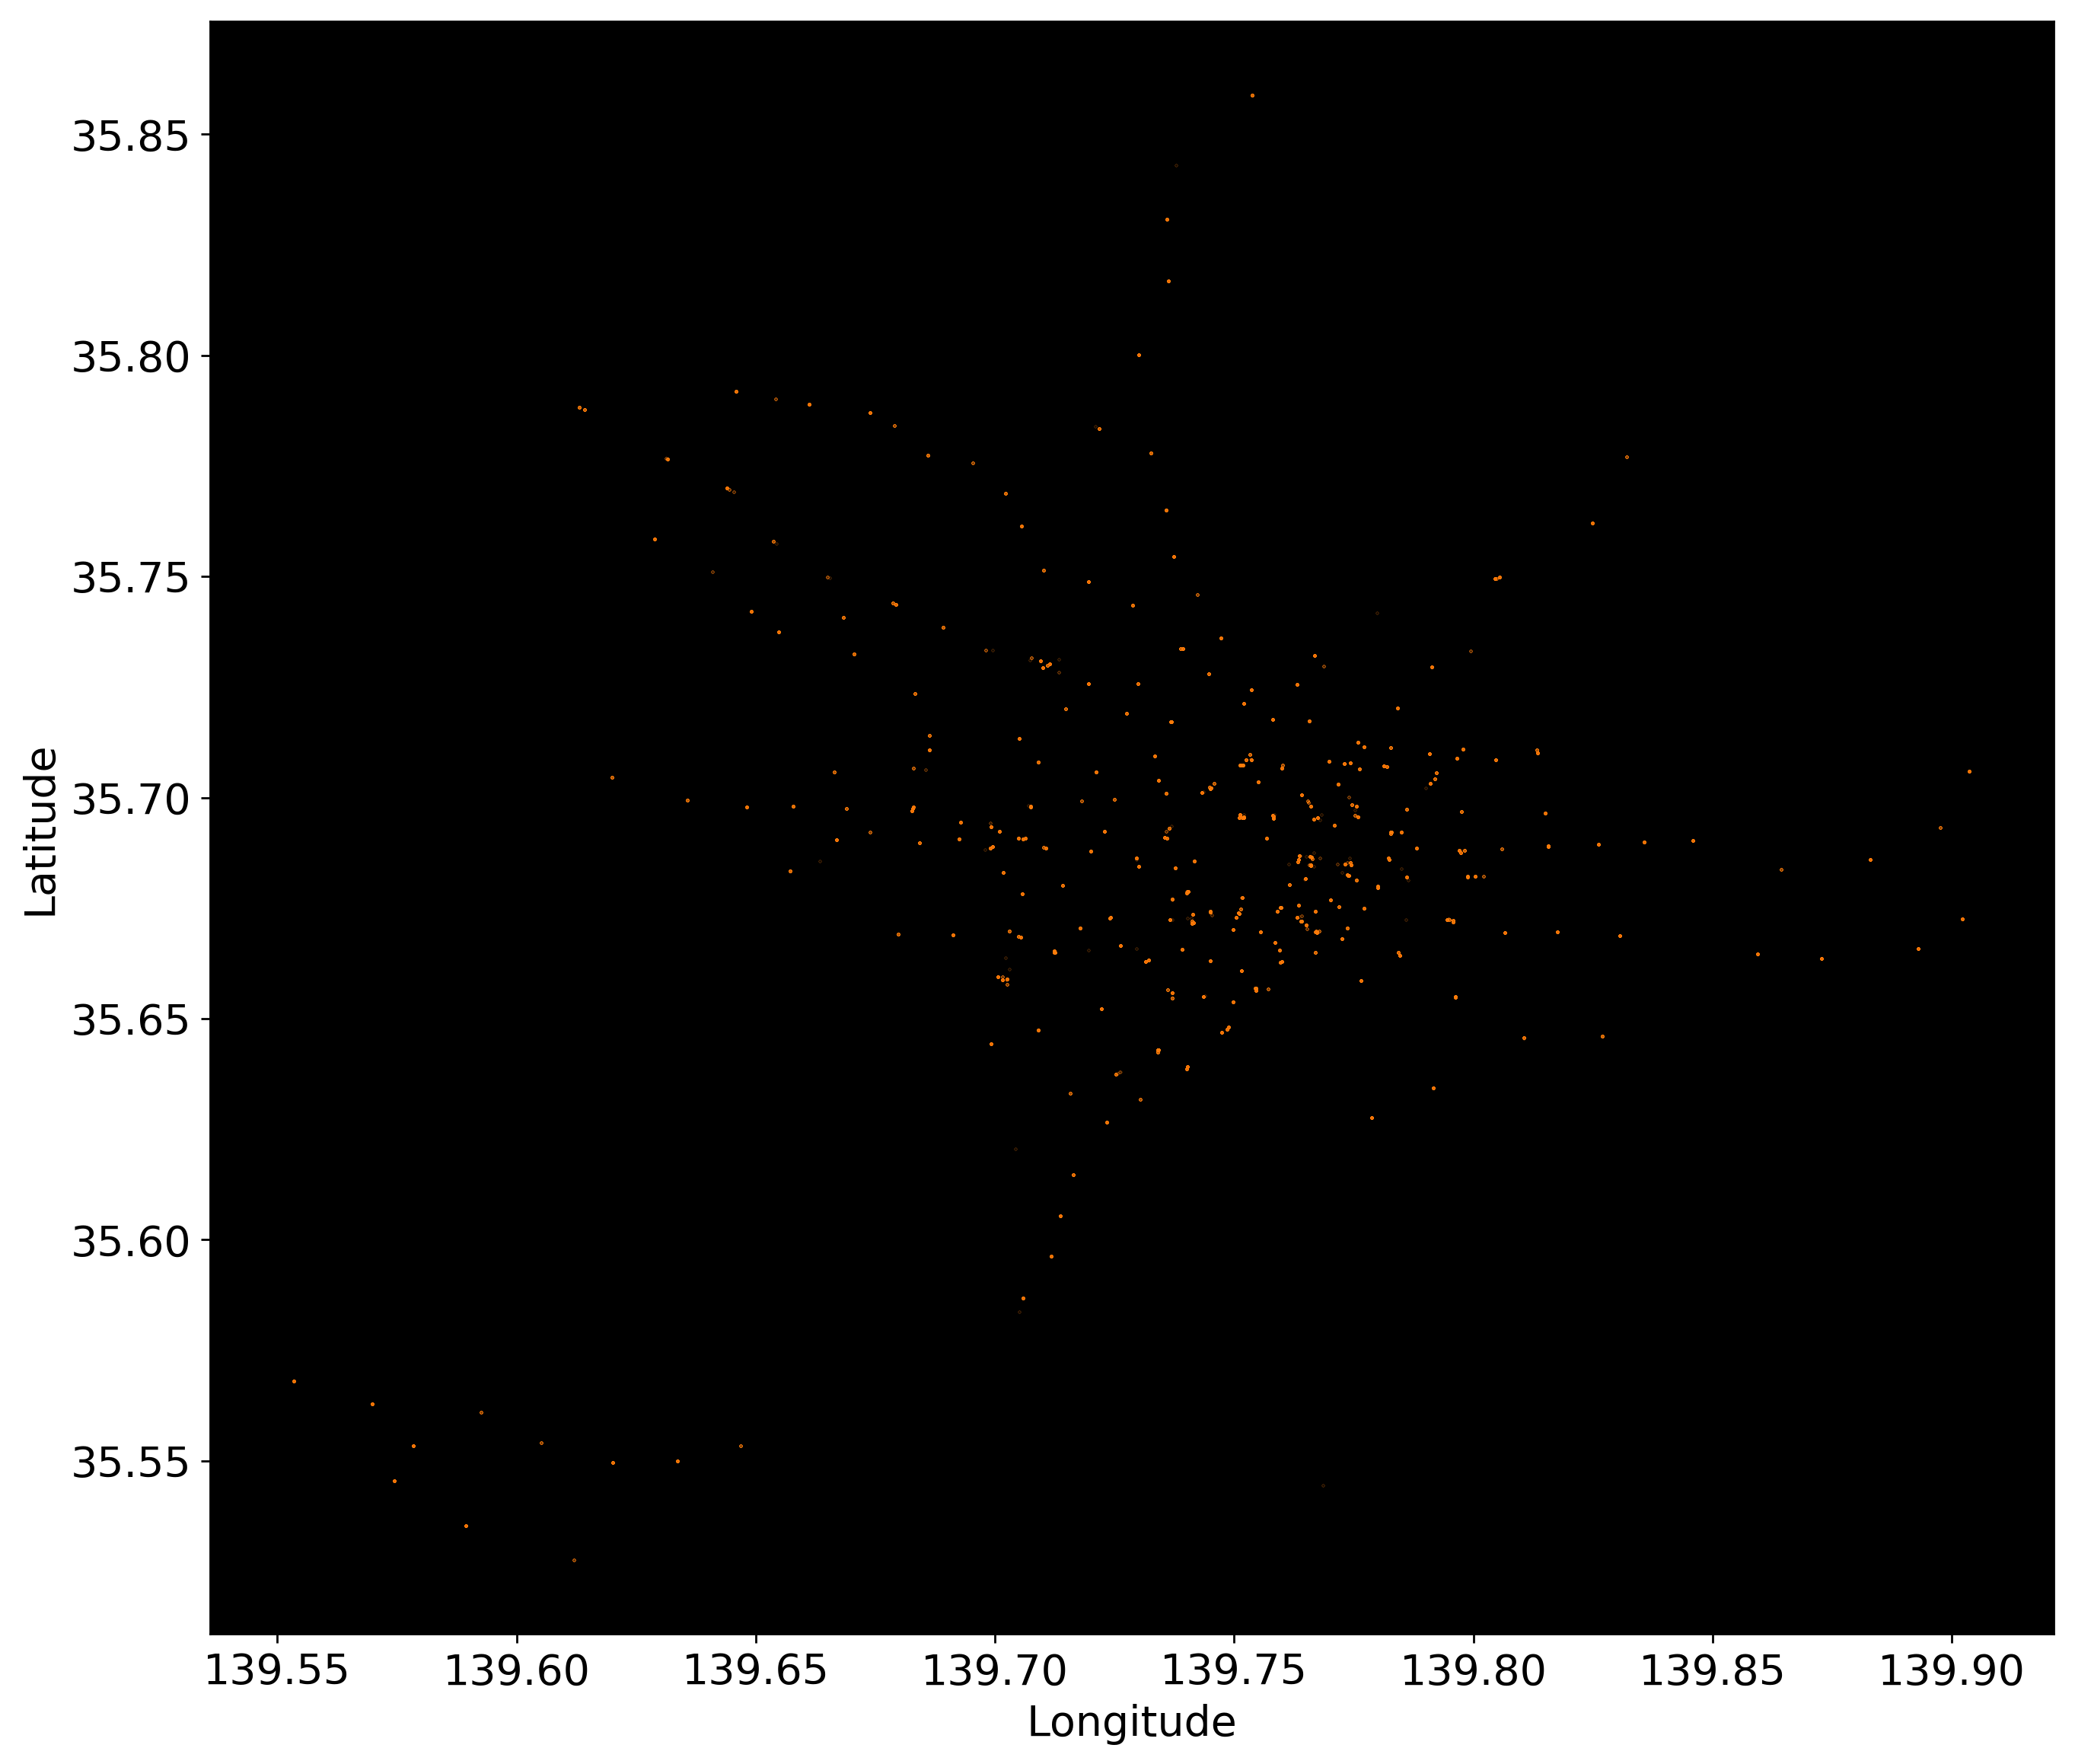

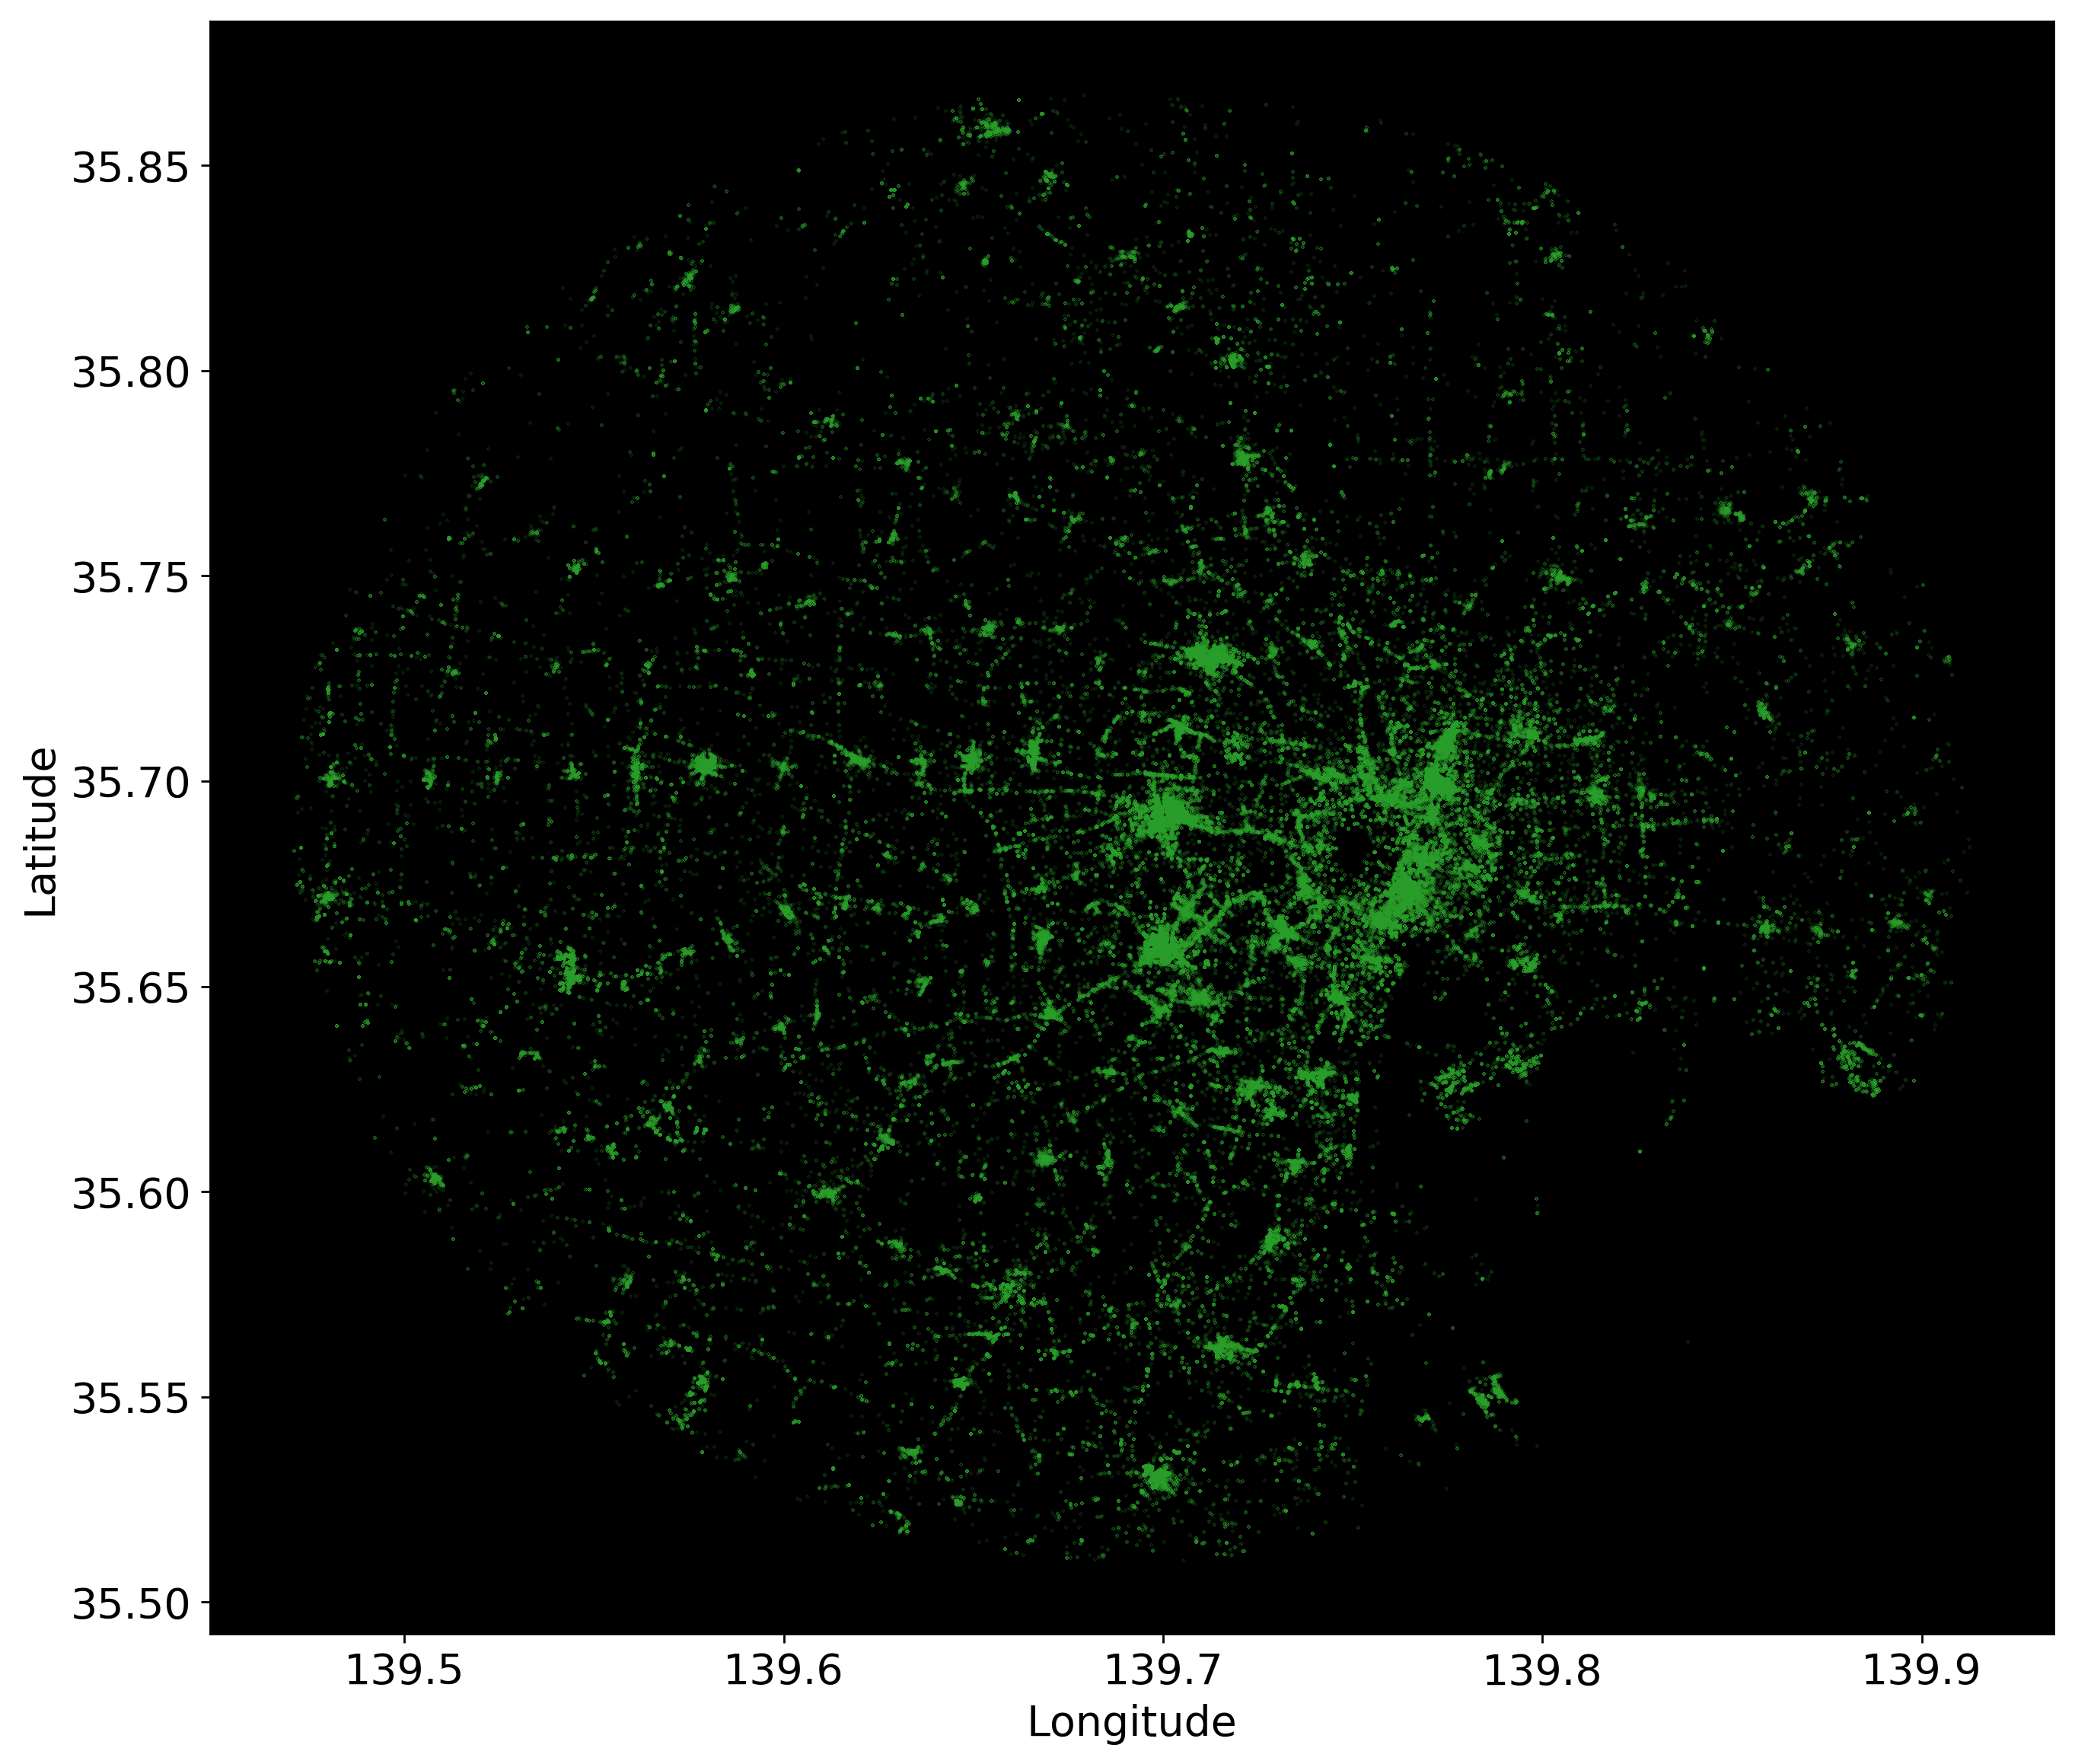

In [18]:
mapsettings(12.5,11,250)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow']

for y0 in y0s:
    fig, ax = plt.subplots()
    df[df["y0"] == y0].plot(kind = 'scatter', x = 'long', y = 'lat', color = colors[y0], s = 0.02, alpha = 0.6, ax = ax) 
    ax.set_facecolor('black')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

### User-specific check-ins according to GPS coordinates, for Train Station, Subway, and all others

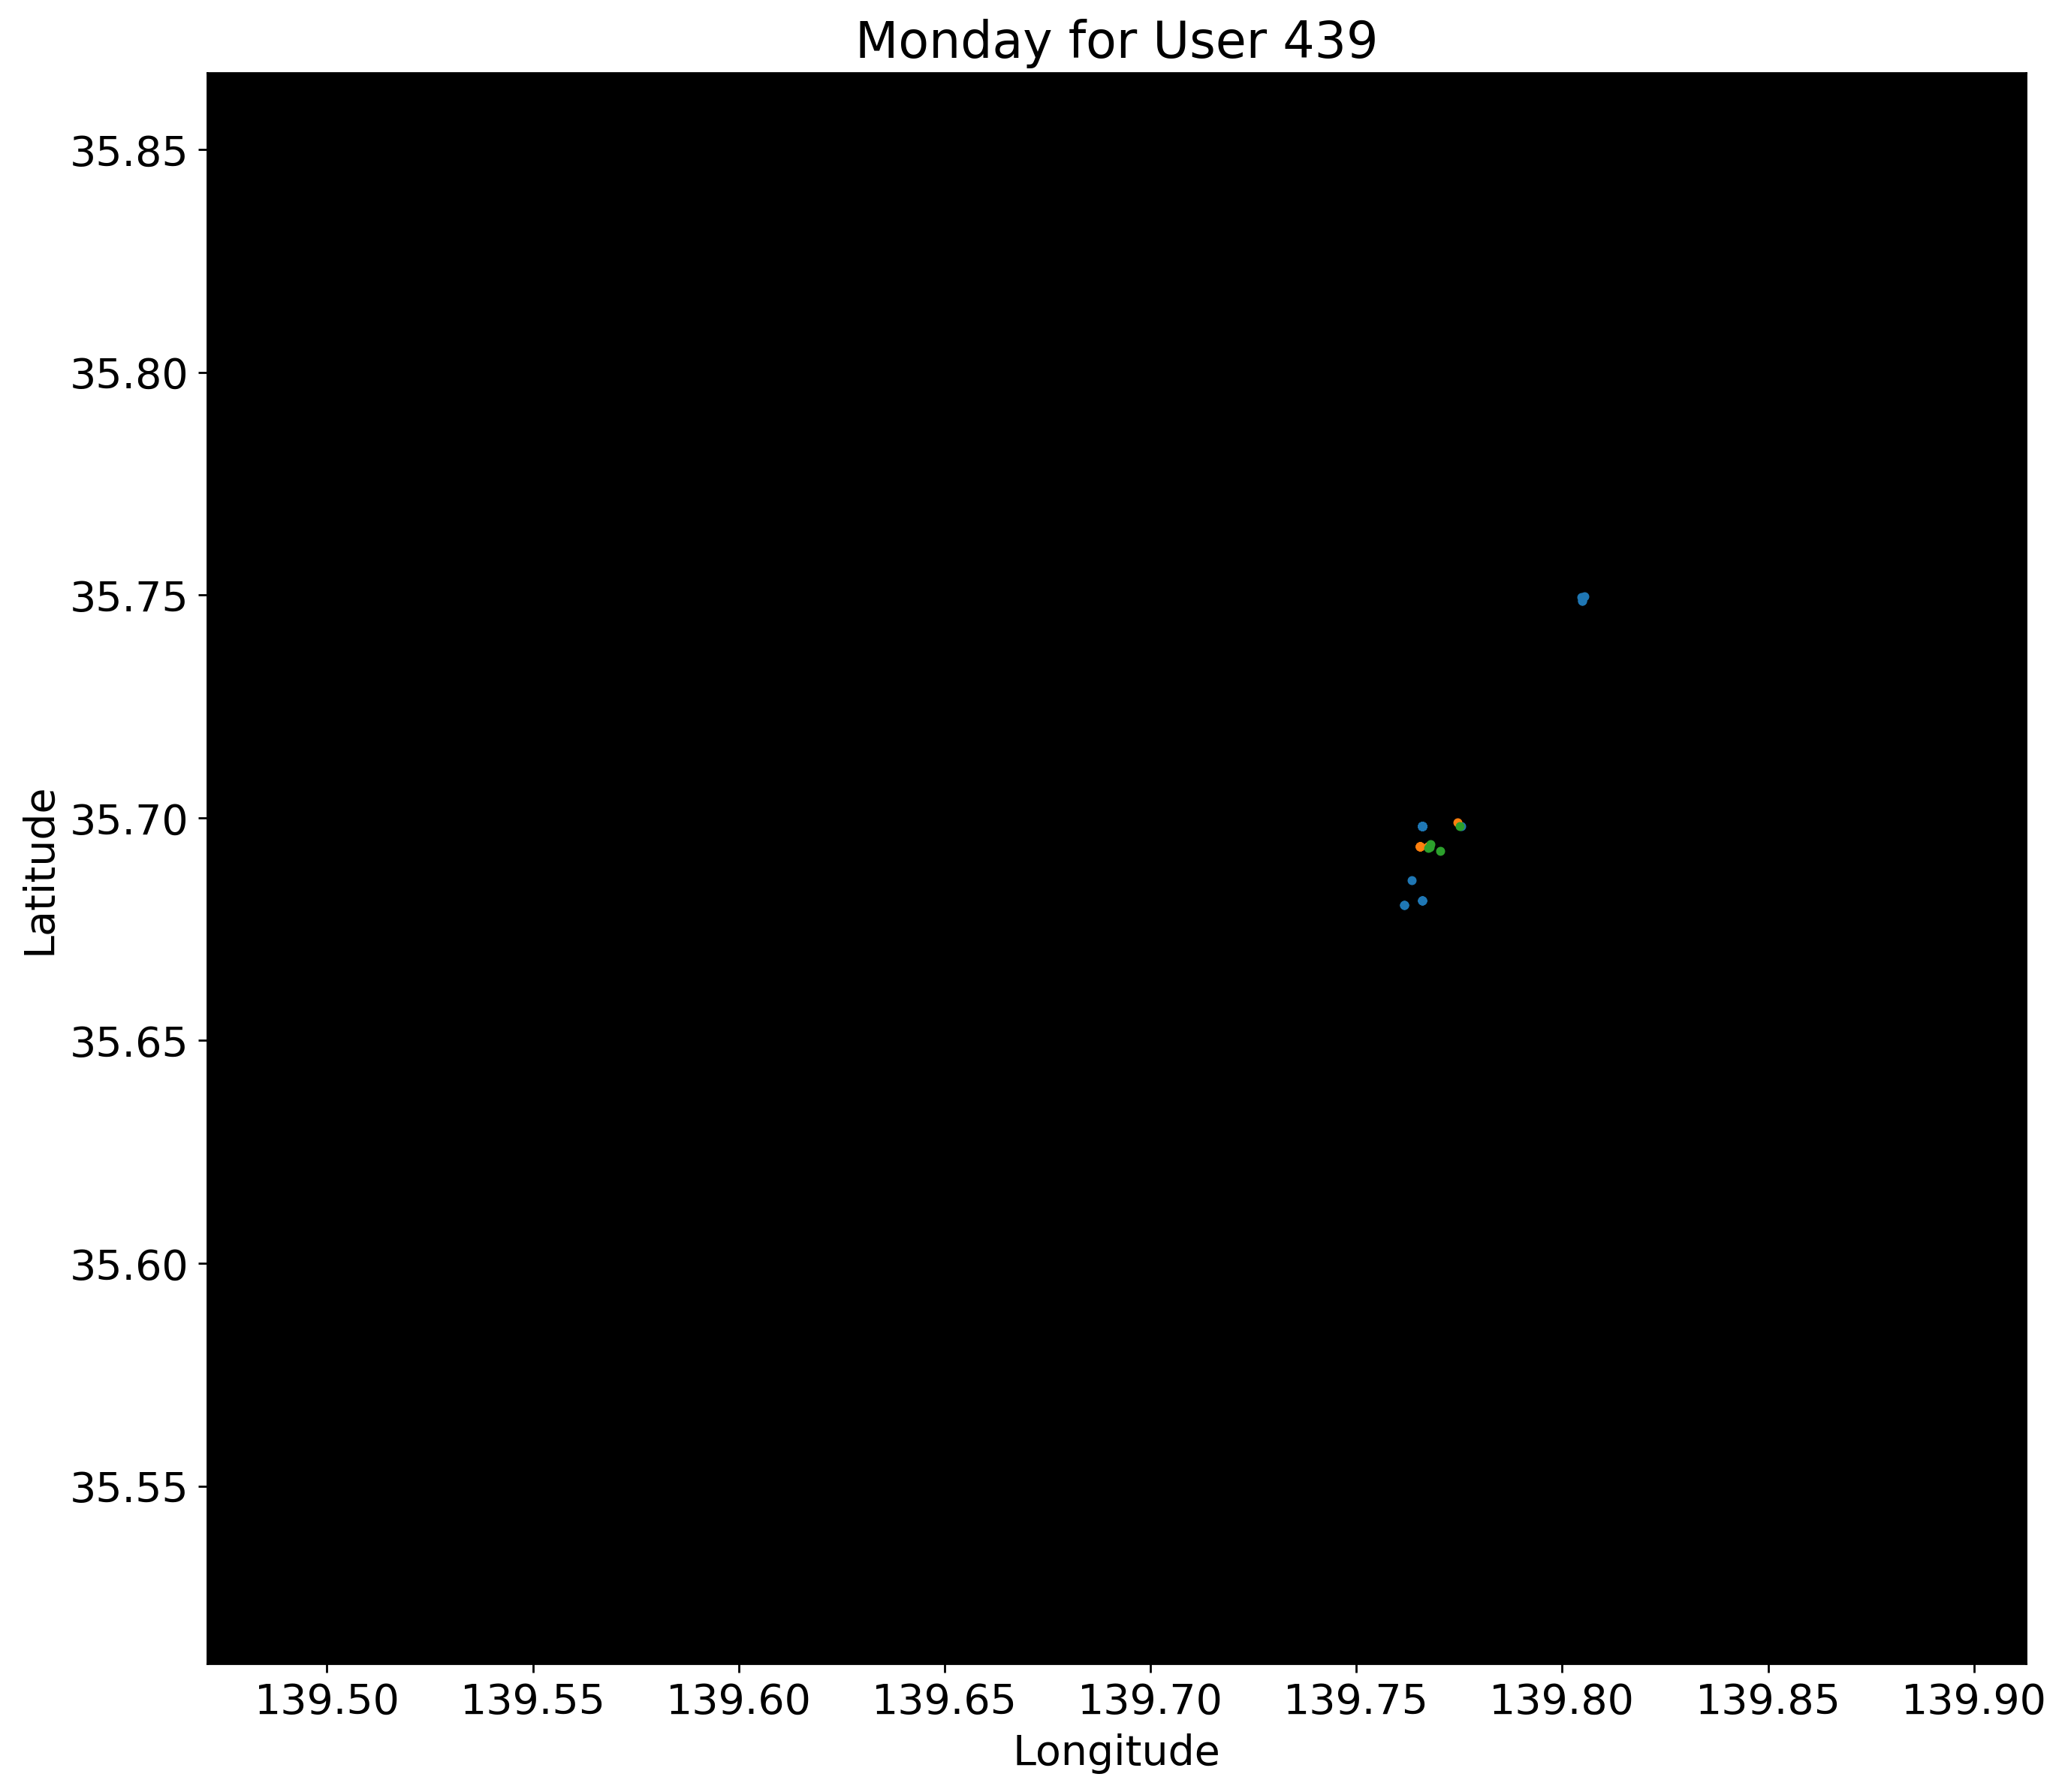

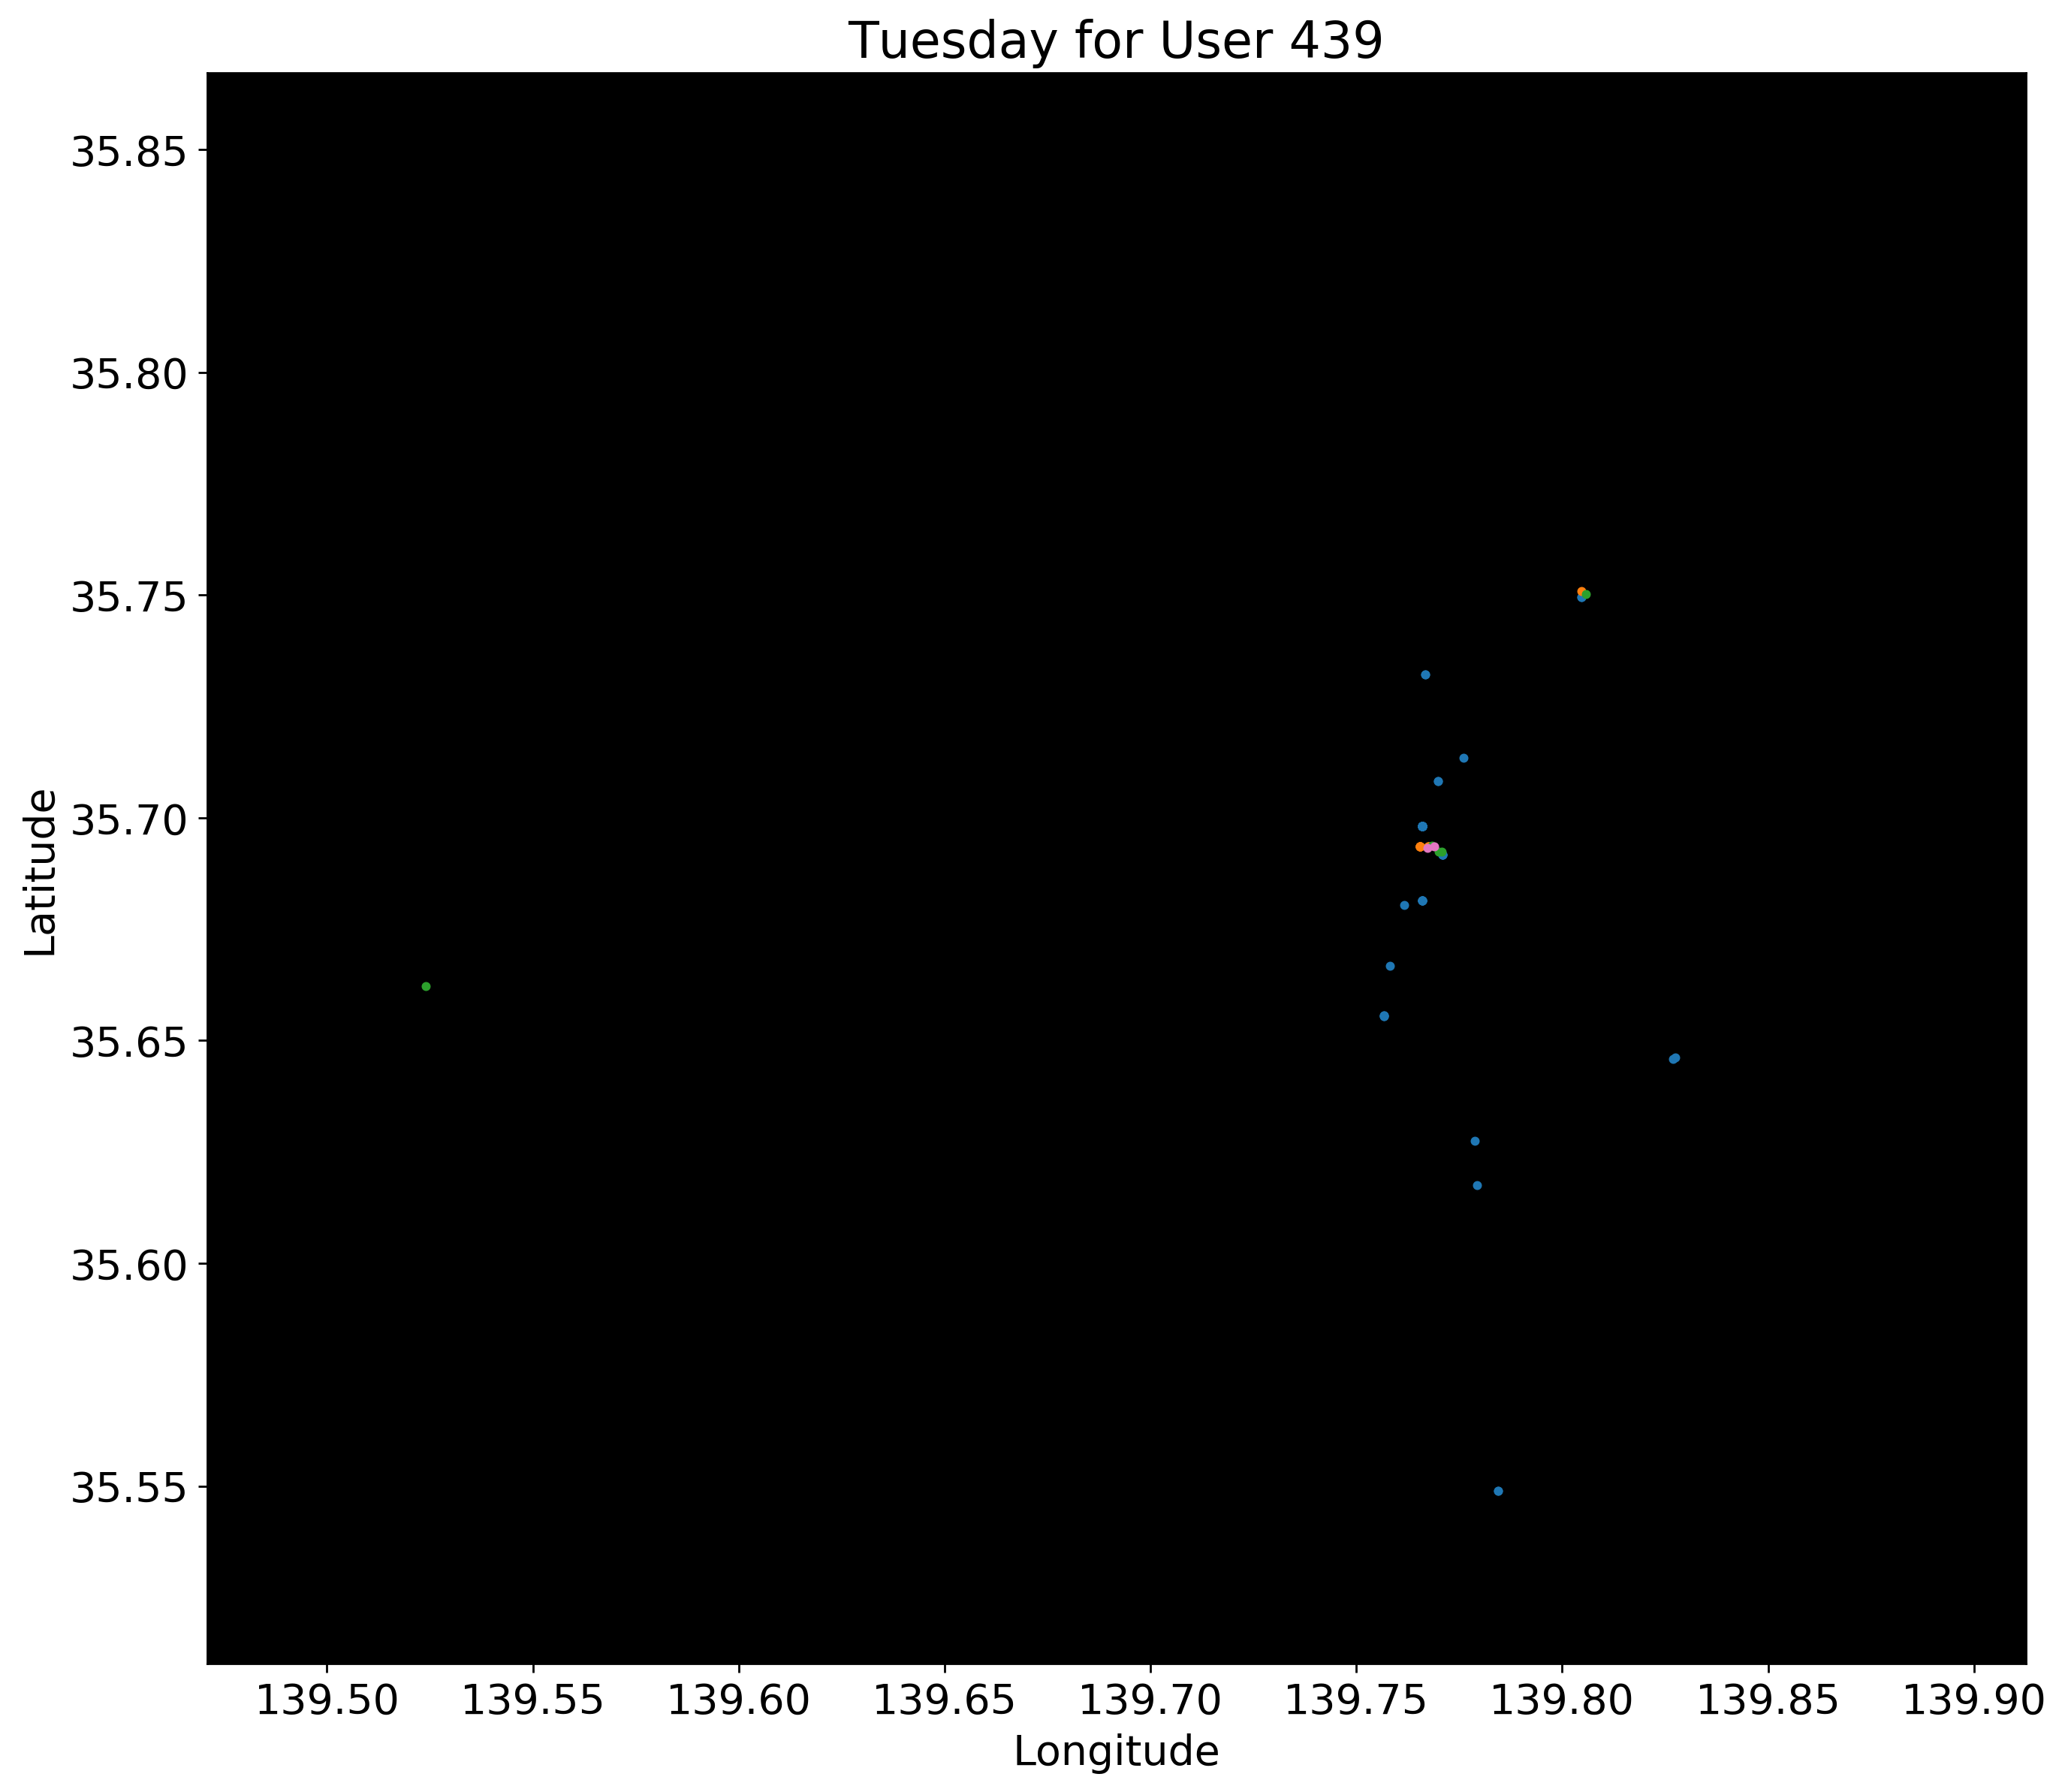

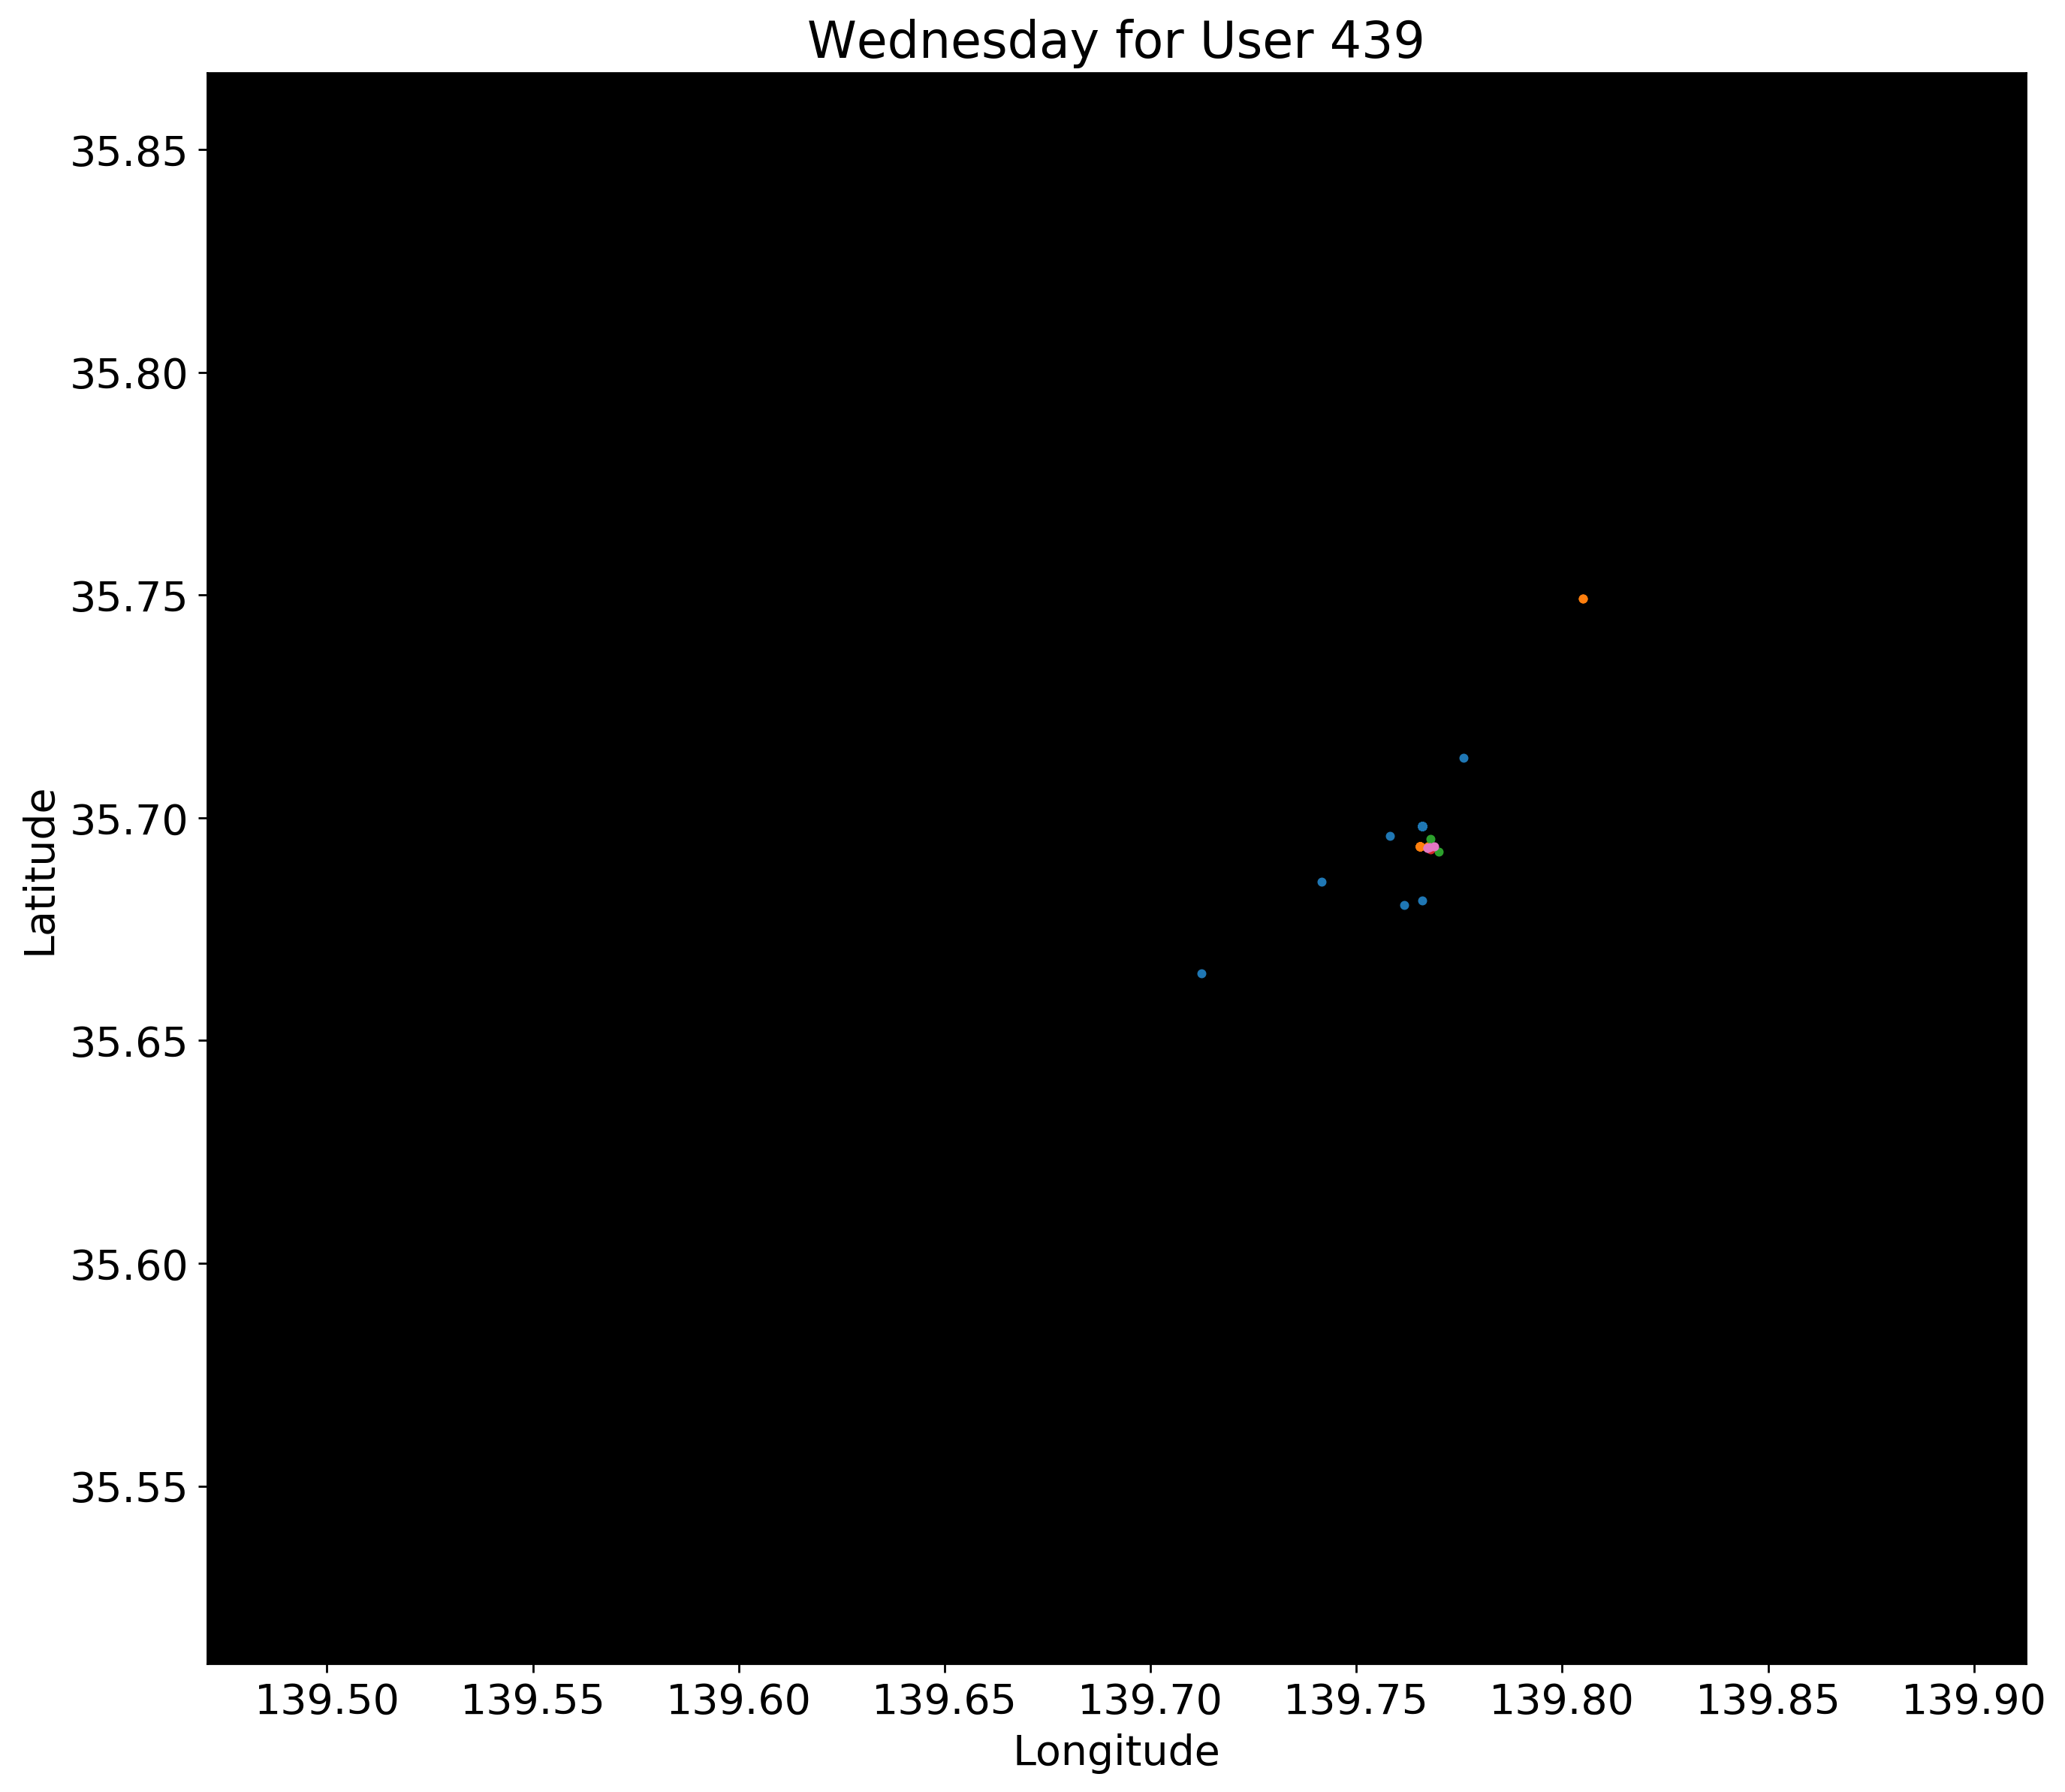

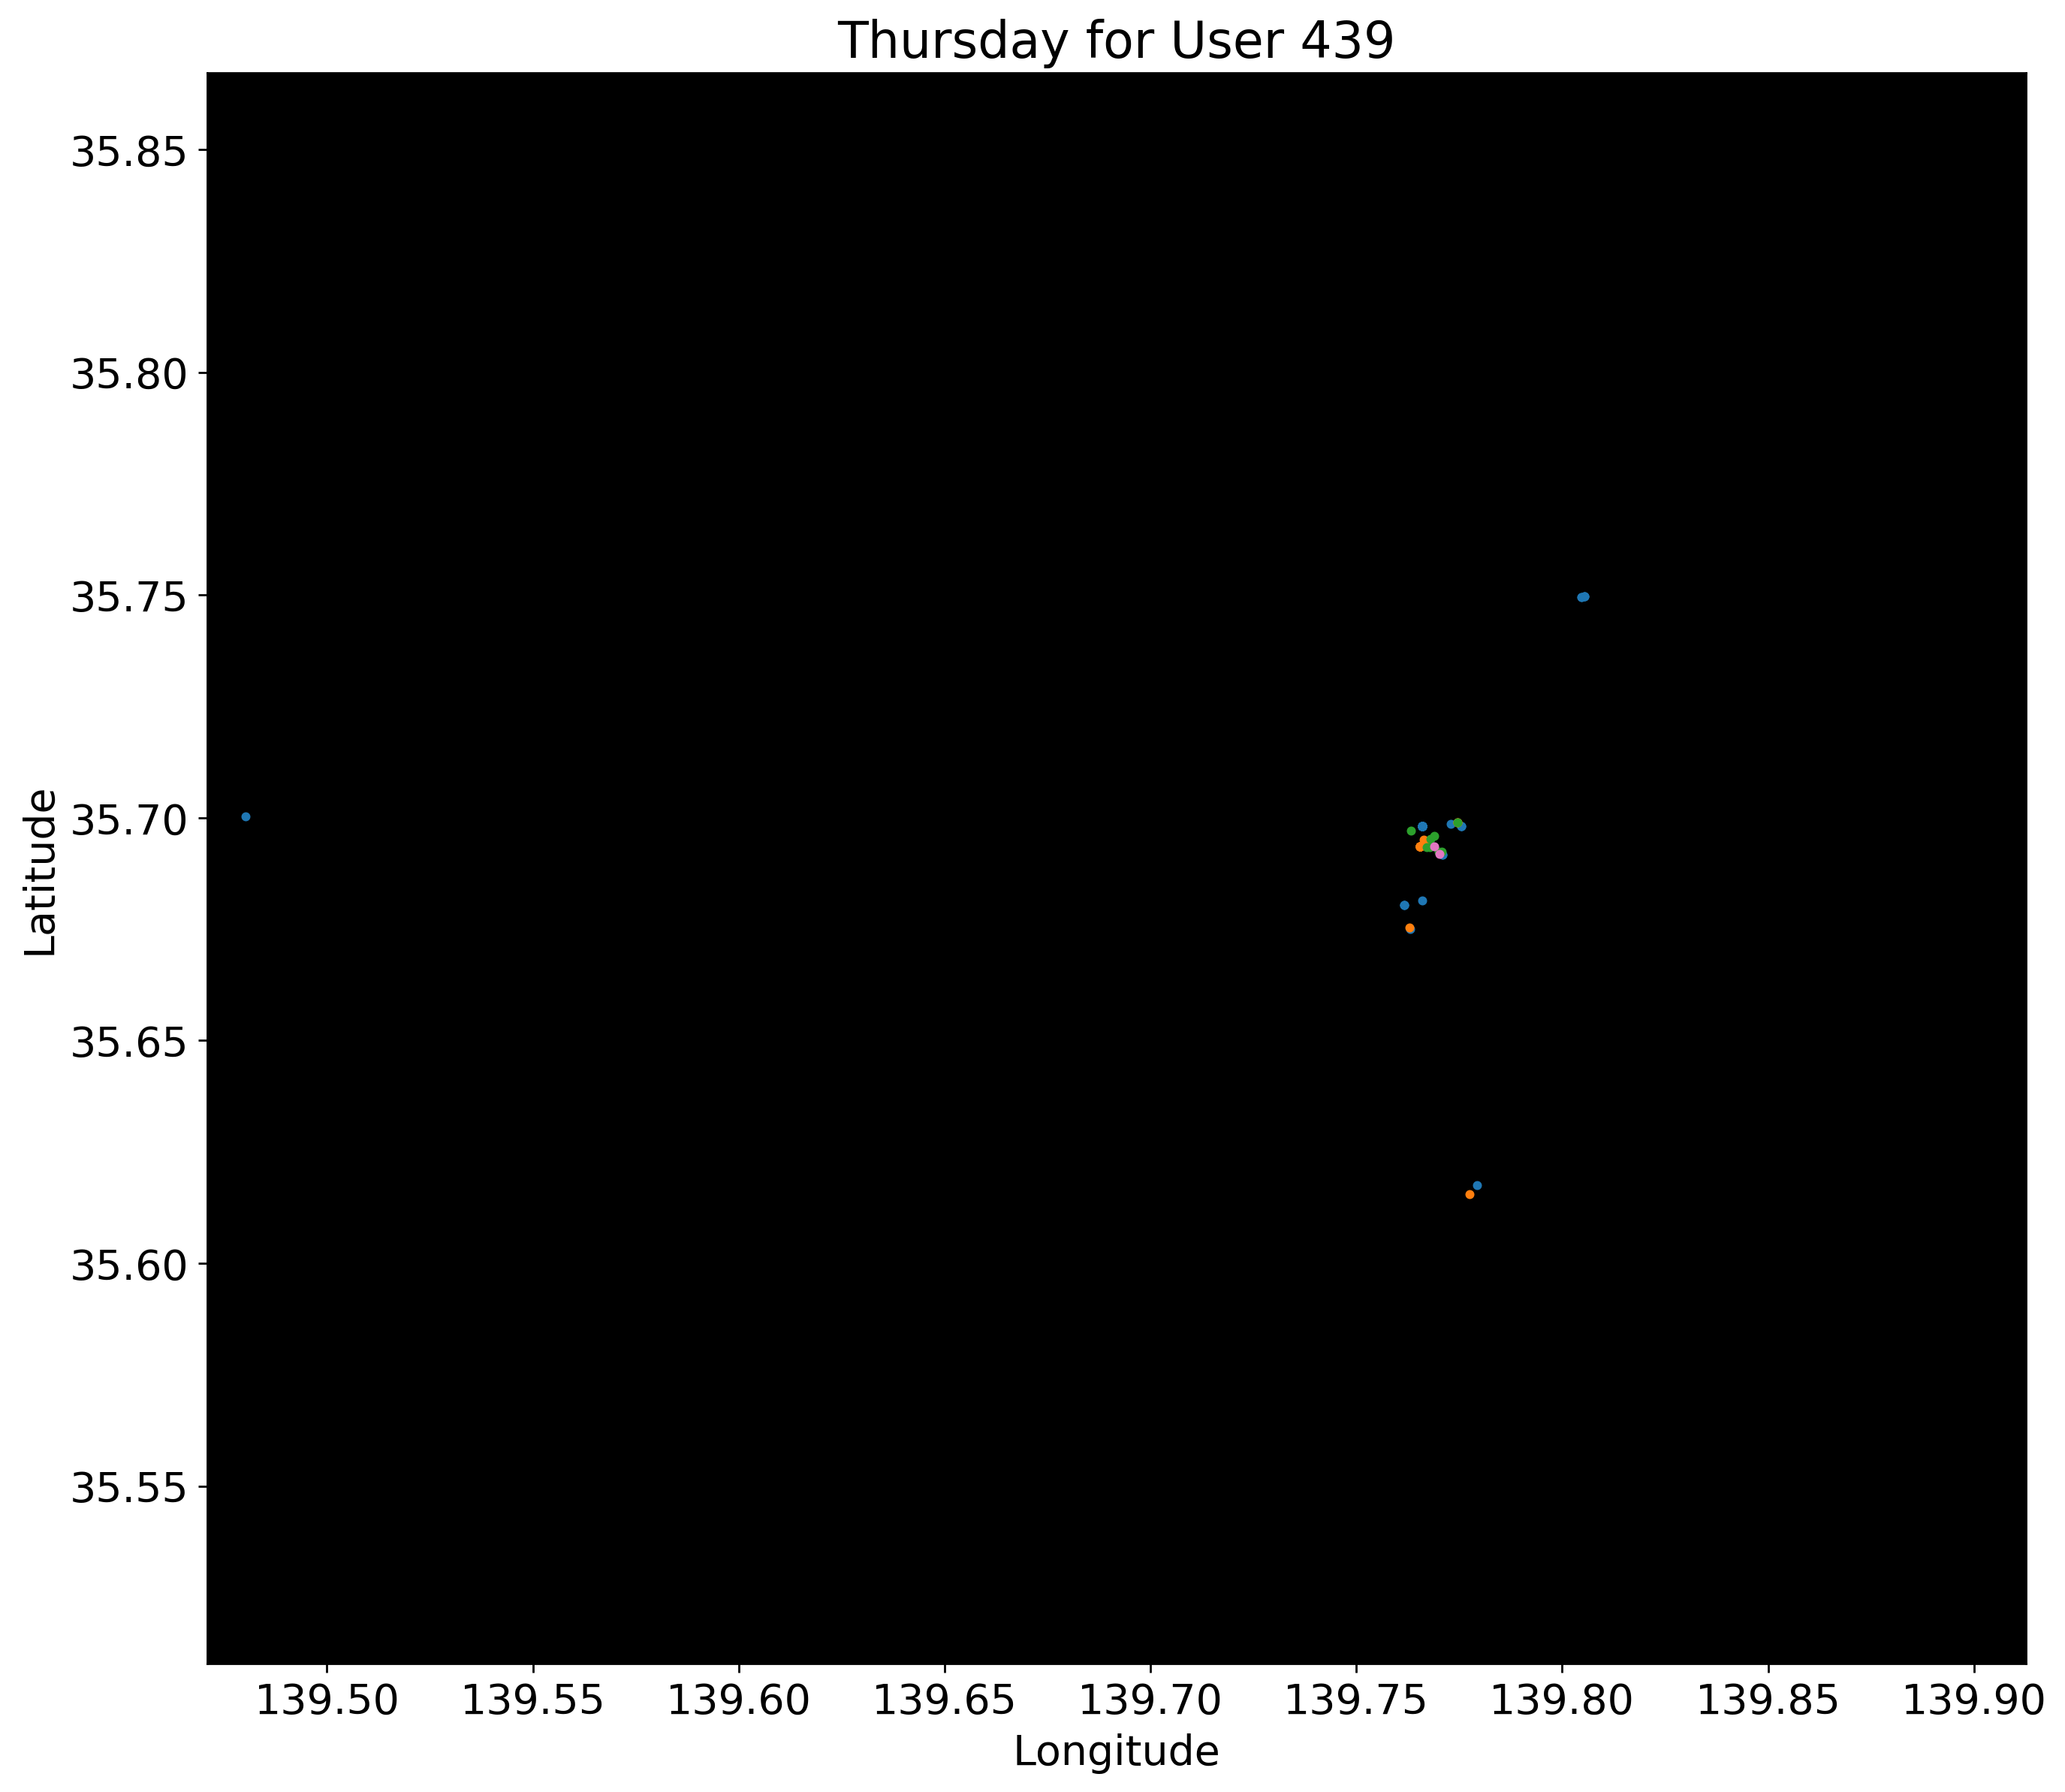

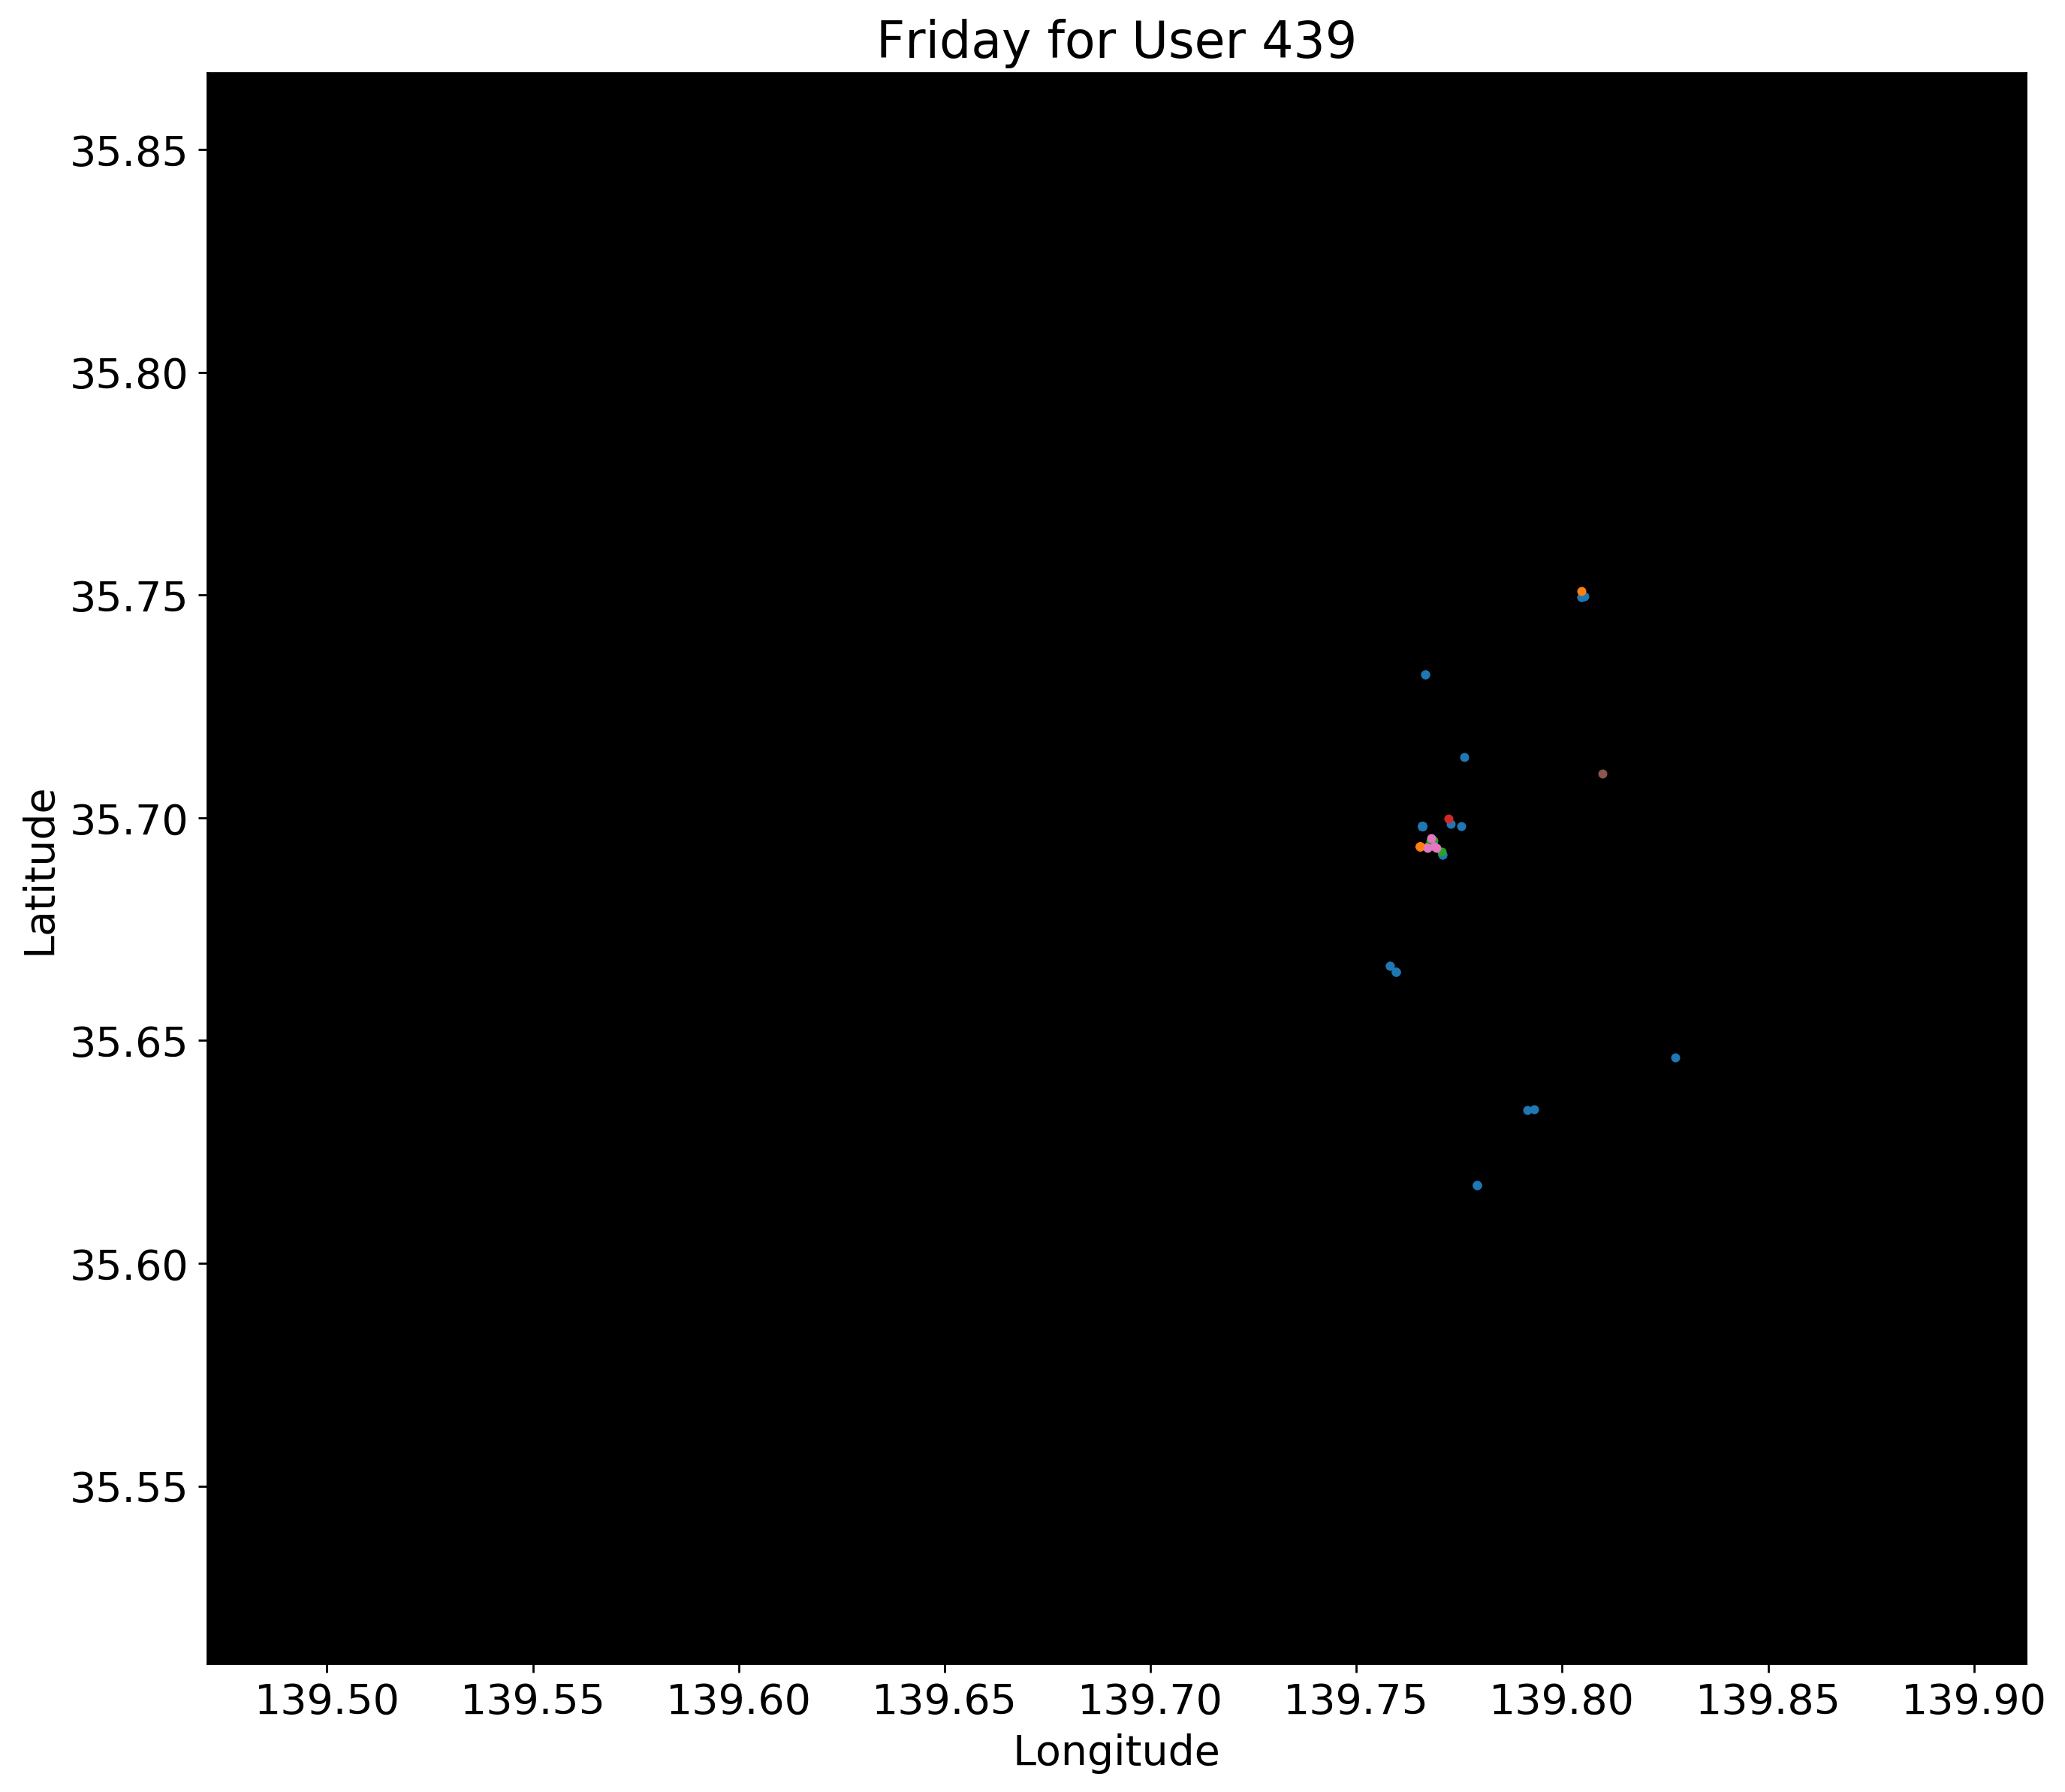

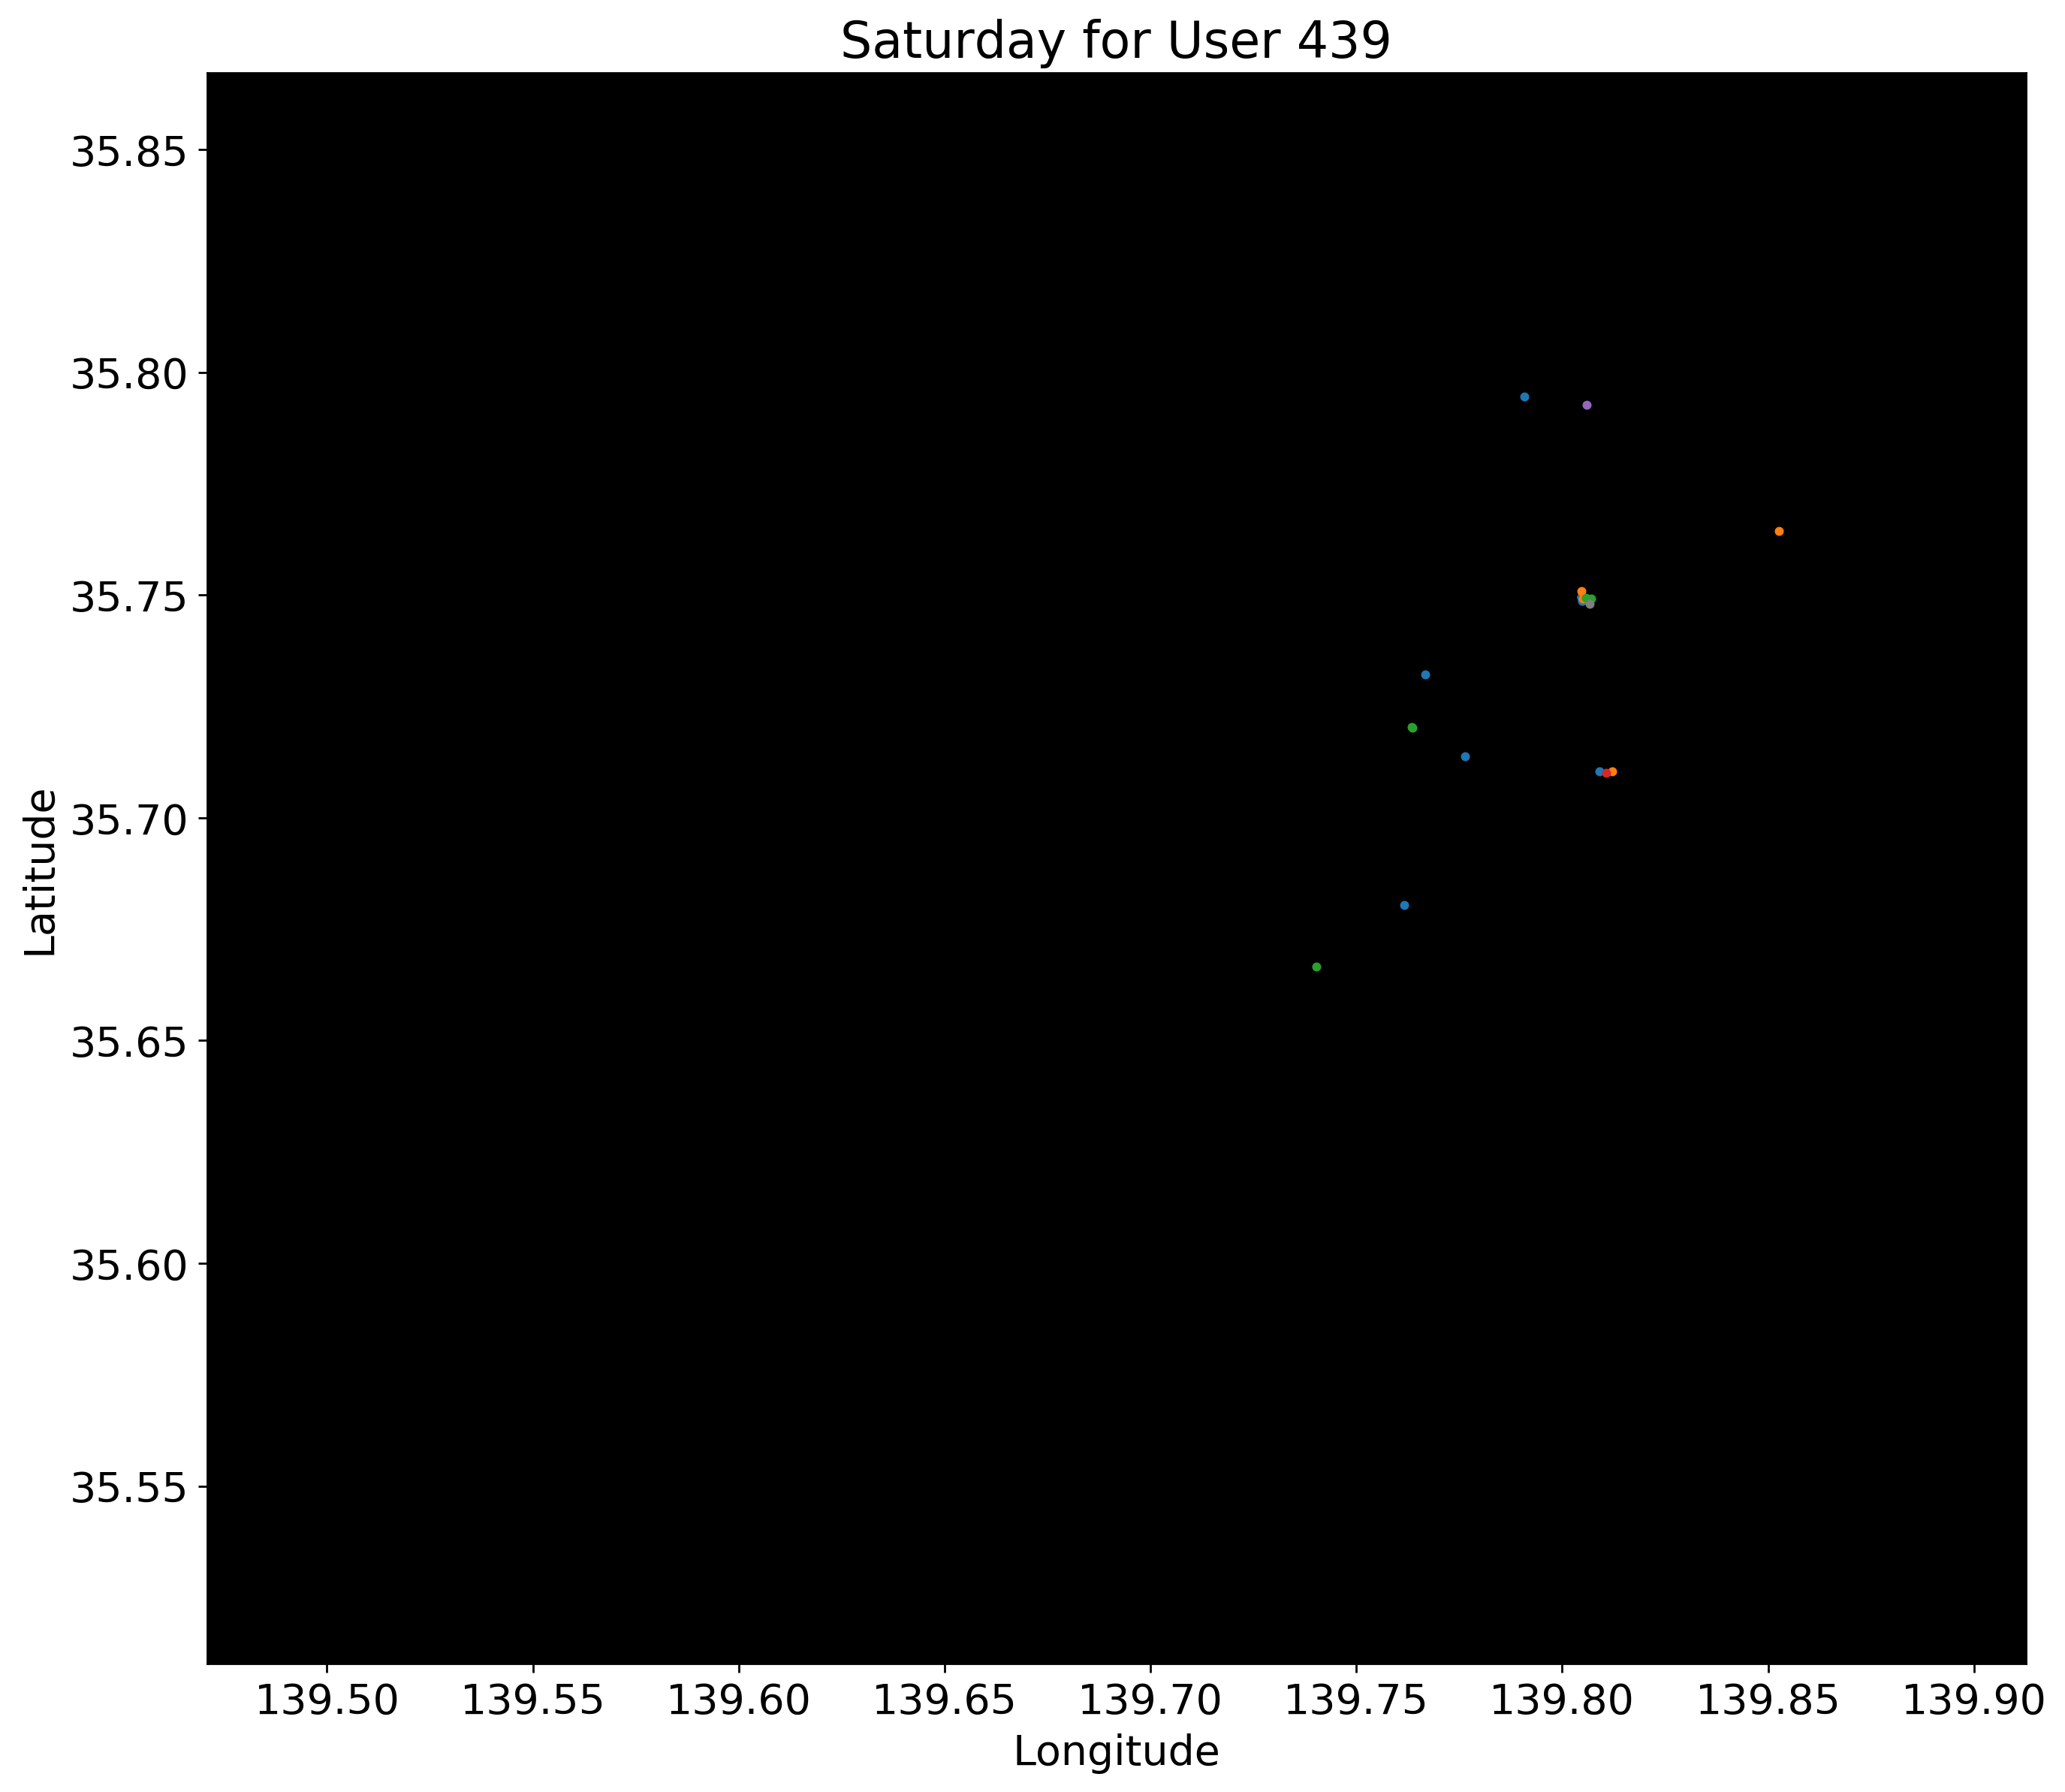

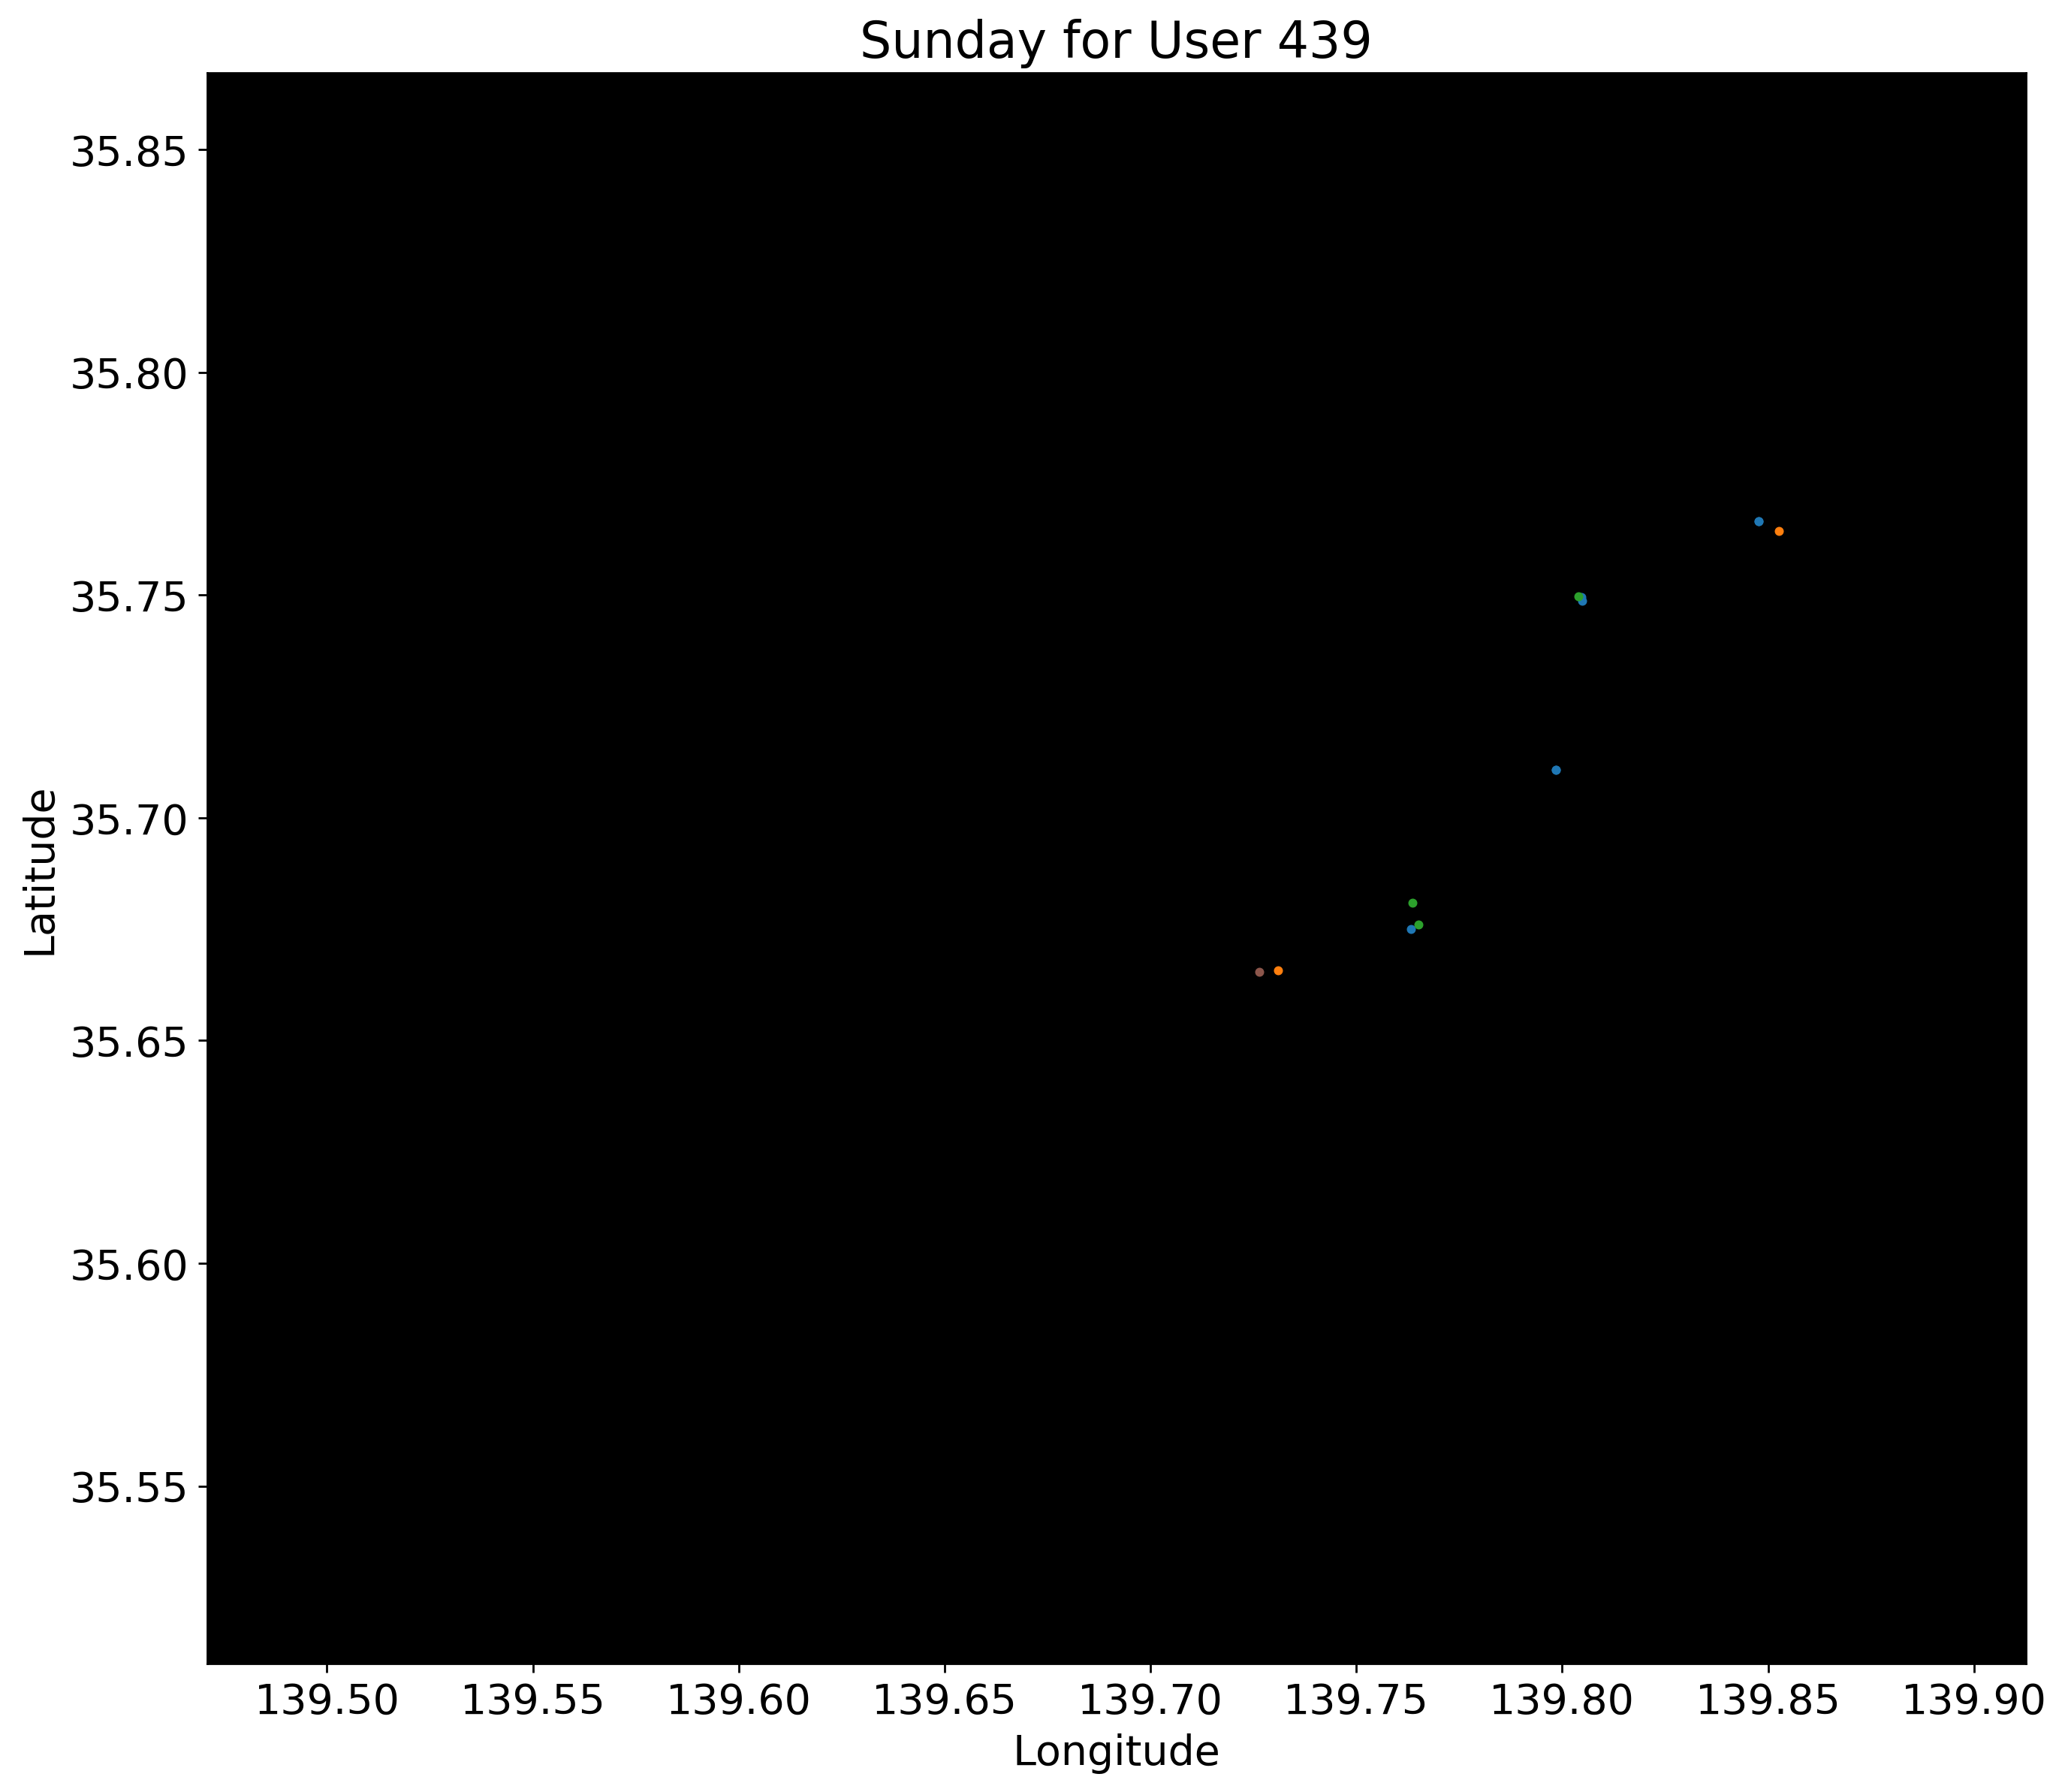

In [19]:
mapsettings(12.5,11,250)

sample_userid = 439

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

day_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

days = np.arange(7)

xmin, xmax, ymin, ymax = df.long.min(), df.long.max(), df.lat.min(), df.lat.max()

for day in days:
    
    fig, ax = plt.subplots()
    ii = 0

    for maincat in maincats:

        if df[(df.userid == int(sample_userid)) & (df.day == day) & (df.maincat_encoded == maincat)].shape[0]:
        
            df[(df.userid == int(sample_userid)) & (df.day == day) & (df.maincat_encoded == maincat)].plot(kind = 'scatter', x = 'long', y = 'lat', color = colors[ii], s = 6, alpha = 1, ax = ax) 

        ii += 1
    
    ax.set_facecolor('black')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(day_label[day] + " for User " + str(sample_userid))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()